# Imports and Data

In [117]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk1', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [2]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()
    
pikachu = {}
for it in ['it1', 'it2']:
    pikachu[it] = {}
    for ego in tmpdff[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        pikachu[it][f'{thekey[it]}{ego}'] = tmpdff[it][60][ego]
        pikachu['it'] = pikachu.get('it', {})
        pikachu['it'][f'{thekey[it]}{ego}'] = {}
        pikachu['it'][f'{thekey[it]}{ego}'].update(tmpdff[it][60][ego])

raichu = {}
for it in ['it1', 'it2']:
    raichu[it] = {}
    for ego in tmplives[it][60].keys():
        thekey = {"it1": "a", "it2": "b"}
        raichu[it][f'{thekey[it]}{ego}'] = tmplives[it][60][ego]
        raichu['it'] = raichu.get('it', {})
        raichu['it'][f'{thekey[it]}{ego}'] = {}
        raichu['it'][f'{thekey[it]}{ego}'].update(tmplives[it][60][ego])

In [3]:
lives = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    if (c == 'it1') or (c == 'it2'):
        lives[c] = raichu[c]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'it':
        lives[c] = raichu[c]
    elif c in ['uk1', 'uk2']:
        lf = pc.lives_dictionary(calls[c])
        for ego in lf.keys():
            for alter in lf[ego].keys():
                ell = lf[ego][alter]['ell']
                if ell > 300:
                    lf[ego][alter]['ell'] = 300
        lives[c] = {}
        for ego in lf.keys():
            thekey = f'{forkey[c]}{ego}'
            lives[c][thekey] = lf[ego]
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])
    elif c == 'uk':
        lives[c] = {}
        for u in ['uk1', 'uk2']:
            lives[c].update(lives[u])
    else:
        lives[c] = pc.lives_dictionary(calls[c])
        lives['all'] = lives.get('all', {})
        lives['all'].update(lives[c])

In [4]:
dffcomb = {}
for c in ['it', 'it1', 'it2']:
    dffcomb[c] = pikachu[c]

dffcomb['uk'] = {}
for c in ['uk1', 'uk2']:
    ddf = pc.get_f(calls[c], 'all', 15, 10)
    dffcomb[c] = {}
    forkey = {'uk1': 'a', 'uk2': 'b'}
    for ego in ddf.keys():
        dffcomb[c][f'{forkey[c]}{ego}'] = {}
        for alter in ddf[ego].keys():
            df1 = ddf[ego][alter]
            df2 = df1.loc[(df1['alpha'] <= 20)]
            dffcomb[c][f'{forkey[c]}{ego}'][alter] = df2
            dffcomb['uk'][f'{forkey[c]}{ego}'] = dffcomb['uk'].get(f'{forkey[c]}{ego}', {})
            dffcomb['uk'][f'{forkey[c]}{ego}'][alter] = dffcomb['uk'][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffcomb['mit'] = pc.get_f(calls['mit'], 'all', 15, 10)

In [5]:
limits = [(0, 50), (100, 150), (220, 270)]

In [6]:
t0 = dt.datetime.now()

fig1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = {}
        fig1[c][i]['f'] = pc.get_avgfa(dffcomb[c], lives[c], limits[i][0], limits[i][1])
        fig1[c][i]['fi'] = {}
        for ego in dffcomb[c].keys():
            tmp = {ego: dffcomb[c][ego]}
            fig1[c][i]['fi'][ego] = pc.get_avgfa(tmp, lives[c], limits[i][0], limits[i][1])
        
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:01.770620


In [7]:
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
[[1, 2], [0.8944473463826683, 0.8944473463826683], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8944473463826683) -- (axis cs: 2, 0.8944473463826683);
[[1, 9], [1.5723282598956279, 1.5723282598956279], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.701645707584401) -- (axis cs: 7, 1.701645707584401);
[[1, 17], [2.5619741459106, 2.5619741459106], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2.881431126435454) -- (axis cs: 13, 2.881431126435454);
=======================uk2=====================
[[1, 2], [0.6647318258067262, 0.6647318258067262], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
[[1, 9], [1.571091122048576, 1.571091122048576], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
[[1, 16], [2.481956286684663, 2.481956286684663], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 

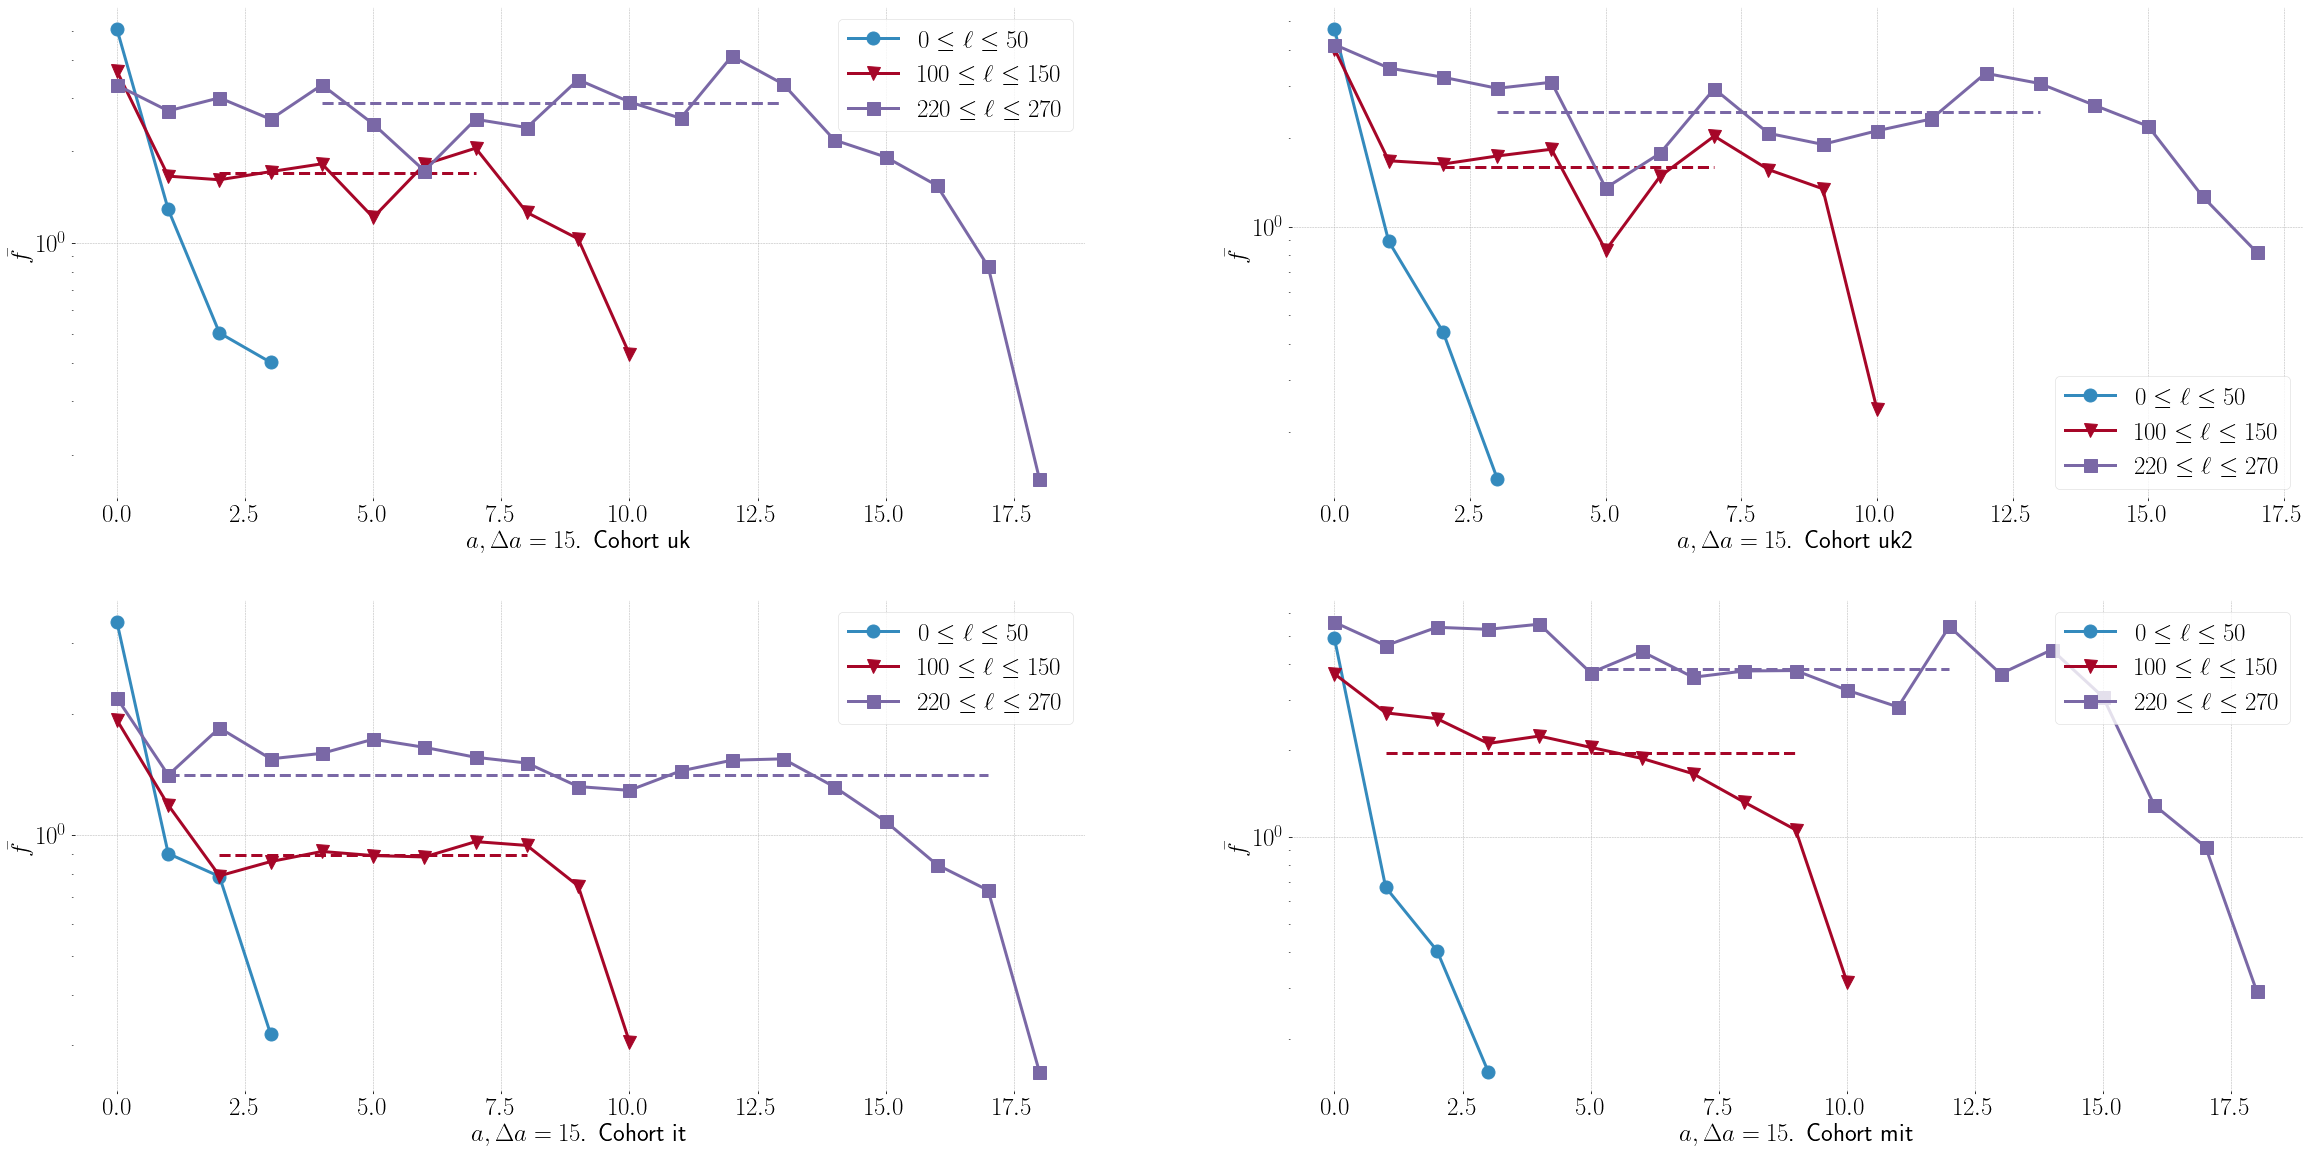

In [8]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    #plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    #plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        if i > 0:
            plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

In [9]:
# for c in fig1.keys():
#     tmp = pd.DataFrame()
#     for l in fig1[c].keys():
#         df = fig1[c][l]
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1_{c}.dat", header=True, sep="\t")

# Fig 2

In [10]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

In [11]:
tmp = pd.DataFrame(index=range(111))
lists = []
for c in ksp.keys():
    for k in ['m', 'l']:
        thelist = ksp[c][k]
        lists.append(thelist)
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{k}'] = thelist[i]

In [12]:
for c in ksp.keys():
    for k in ksp[c].keys():
        lista = ksp[c][k]
        count = 0
        for i in lista:
            if i < 0.05:
                count += 1
        print(c, k, count/len(lista))

uk m 0.0
uk l 0.02040816326530612
uk2 m 0.0
uk2 l 0.041666666666666664
it m 0.0
it l 0.006896551724137931
mit m 0.0
mit l 0.04081632653061224


In [13]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2.dat", index=False, header=True, sep="\t")

In [14]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [15]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego]
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:698: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [16]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist.keys():
    for ell in [1, 2]:
        thelist = bhist[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2down.dat", index=False, header=True, sep="\t")

In [17]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/figs/fig2bmdown.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/figs/fig2bldown.dat", index=True, header=True, sep="\t")

In [18]:
dashed

{'uk': {0: [[1, 2], [0.8944473463826683, 0.8944473463826683]],
  1: [[2, 7], [1.701645707584401, 1.701645707584401]],
  2: [[4, 13], [2.881431126435454, 2.881431126435454]]},
 'uk2': {0: [[1, 2], [0.6647318258067262, 0.6647318258067262]],
  1: [[2, 7], [1.5923360902462018, 1.5923360902462018]],
  2: [[3, 13], [2.4509639574378883, 2.4509639574378883]]},
 'it': {0: [[1, 2], [0.8442913094667548, 0.8442913094667548]],
  1: [[2, 8], [0.891389010039064, 0.891389010039064]],
  2: [[1, 17], [1.4098818880803792, 1.4098818880803792]]},
 'mit': {0: [[1, 2], [0.536811285664926, 0.536811285664926]],
  1: [[1, 9], [1.9573264544906632, 1.9573264544906632]],
  2: [[5, 12], [3.8447671707204325, 3.8447671707204325]]}}

# Fig 3 with resampling

In [19]:
dffsurv = {}
dffsurv['all'] = {}
for c in dffcomb.keys():
    if c in ['it1', 'it2', 'uk1', 'uk2', 'mit']:
        dffsurv['all'].update(dffcomb[c])
    if c in ['uk', 'uk2', 'it', 'mit']:
        dffsurv[c] = dffcomb[c]

In [20]:
fig3 = {}
for c in dffsurv.keys():
    fig3[c] = pc.get_survival(dffsurv[c], alphafixed=(2,3), externalell=lives[c], lambdamax=27)

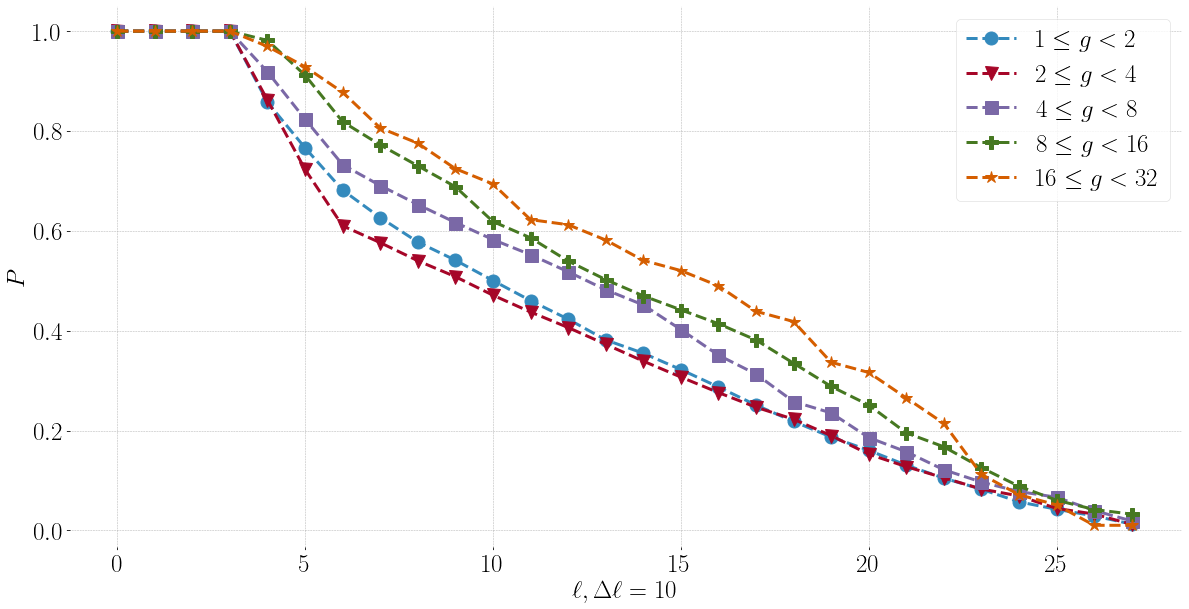

In [21]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(5):
    plt.plot(fig3['all'][i].index, fig3['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

In [22]:
tmp = pd.DataFrame({'lc': list(fig3['all'][0].index)})
for s in range(6):
    df = fig3['all'][s]
    tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvival.dat', header=True, index=False, sep="\t")

# Fig 4 with resampling

In [23]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUM, lambdamax = 25, alphafixed=(2,3), externalell=lives['all'])

In [24]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [25]:
points_it = pc.get_survival(dffsurv['it'], unbinned=True, lambdamax=25, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_it.keys():
    if s <= 2**5 + 1:
        df = points_it[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# SI with resampling

## Using different values for $\Delta t_w$

In [26]:
unfiltered.keys()

dict_keys(['mit', 'uk1', 'uk2', 'uk', 'all'])

In [27]:
t0 = dt.datetime.now()

with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()
    
venonat = {}
for it in ['it1', 'it2']:
    venonat[it] = {}
    for tw in [10, 30, 60, 90]:
        venonat[it][tw] = {}
        for ego in tmpdff[it][tw].keys():
            thekey = {"it1": "a", "it2": "b"}
            venonat[it][tw][f'{thekey[it]}{ego}'] = tmpdff[it][tw][ego]
            venonat['it'] = venonat.get('it', {})
            venonat['it'][tw] = venonat['it'].get(tw, {})
            venonat['it'][tw][f'{thekey[it]}{ego}'] = {}
            venonat['it'][tw][f'{thekey[it]}{ego}'].update(tmpdff[it][tw][ego])

venomoth = {}
for it in ['it1', 'it2']:
    venomoth[it] = {}
    for tw in [10, 30, 60, 90]:
        venomoth[it][tw] = {}
        for ego in tmplives[it][tw].keys():
            thekey = {"it1": "a", "it2": "b"}
            venomoth[it][tw][f'{thekey[it]}{ego}'] = tmplives[it][tw][ego]
            venomoth['it'] = venomoth.get('it', {})
            venomoth['it'][tw] = venomoth['it'].get(tw, {})
            venomoth['it'][tw][f'{thekey[it]}{ego}'] = {}
            venomoth['it'][tw][f'{thekey[it]}{ego}'].update(tmplives[it][tw][ego])
        
livestw = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit', 'it', 'uk']:
    livestw[c] = {}
    for tw in [10, 30, 60, 90]:
        if (c == 'it1') or (c == 'it2'):
            livestw[c][tw] = venomoth[c][tw]
            livestw['all'] = livestw.get('all', {})
            livestw['all'][tw] = livestw['all'].get(tw, {})
            livestw['all'][tw].update(livestw[c][tw])
        elif c == 'it':
            livestw[c][tw] = venomoth[c][tw]
        elif c in ['uk1', 'uk2']:
            callsdf = pc.apply_filters(unfiltered[c], tw)
            lf = pc.lives_dictionary(callsdf)
            for ego in lf.keys():
                for alter in lf[ego].keys():
                    ell = lf[ego][alter]['ell']
                    if ell > 300:
                        lf[ego][alter]['ell'] = 300
            livestw[c][tw] = {}
            for ego in lf.keys():
                thekey = f'{forkey[c]}{ego}'
                livestw[c][tw][thekey] = lf[ego]
            livestw['all'] = livestw.get('all', {})
            livestw['all'][tw] = livestw['all'].get(tw, {})
            livestw['all'][tw].update(livestw[c][tw])
        elif c == 'uk':
            livestw[c][tw] = {}
            for u in ['uk1', 'uk2']:
                livestw[c][tw].update(livestw[u][tw])
        else:
            callsdf = pc.apply_filters(unfiltered[c], tw)
            livestw[c][tw] = pc.lives_dictionary(callsdf)
            livestw['all'] = livestw.get('all', {})
            livestw['all'][tw] = livestw['all'].get(tw, {})
            livestw['all'][tw].update(livestw[c][tw])
        
dfftw = {}
for c in ['it', 'it1', 'it2']:
    dfftw[c] = {}
    for tw in [10, 30, 60, 90]:
        dfftw[c][tw] = venonat[c][tw]

dfftw['uk'] = {}
for c in ['uk1', 'uk2']:
    dfftw[c] = {}
    for tw in [10, 30, 60, 90]:
        dfftw['uk'][tw] = {}
        callsdf = pc.apply_filters(unfiltered[c], tw)
        ddf = pc.get_f(callsdf, 'all', 15, 10)
        dfftw[c][tw] = {}
        forkey = {'uk1': 'a', 'uk2': 'b'}
        for ego in ddf.keys():
            dfftw[c][tw][f'{forkey[c]}{ego}'] = {}
            for alter in ddf[ego].keys():
                df1 = ddf[ego][alter]
                df2 = df1.loc[(df1['alpha'] <= 20)]
                dfftw[c][tw][f'{forkey[c]}{ego}'][alter] = df2
                dfftw['uk'][tw][f'{forkey[c]}{ego}'] = dfftw['uk'][tw].get(f'{forkey[c]}{ego}', {})
                dfftw['uk'][tw][f'{forkey[c]}{ego}'][alter] = dfftw['uk'][tw][f'{forkey[c]}{ego}'].get(alter, df2)
            
dfftw['mit'] = {}
for tw in [10, 30, 60, 90]:
    callsdf = pc.apply_filters(unfiltered['mit'], tw)
    dfftw['mit'][tw] = pc.get_f(callsdf, 'all', 15, 10)

print(f'Took {dt.datetime.now() - t0}')

Took 0:00:44.204846


In [28]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S1[c] = {}
    for Dt in dfftw['uk'].keys():
        S1[c][Dt] = {}
        dff = dfftw[c][Dt]
        for lamb in range(3):
            S1[c][Dt][lamb] = {'f': pc.get_avgfa(dff, livestw[c][Dt], limits[lamb][0], limits[lamb][1])}
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:04.167137


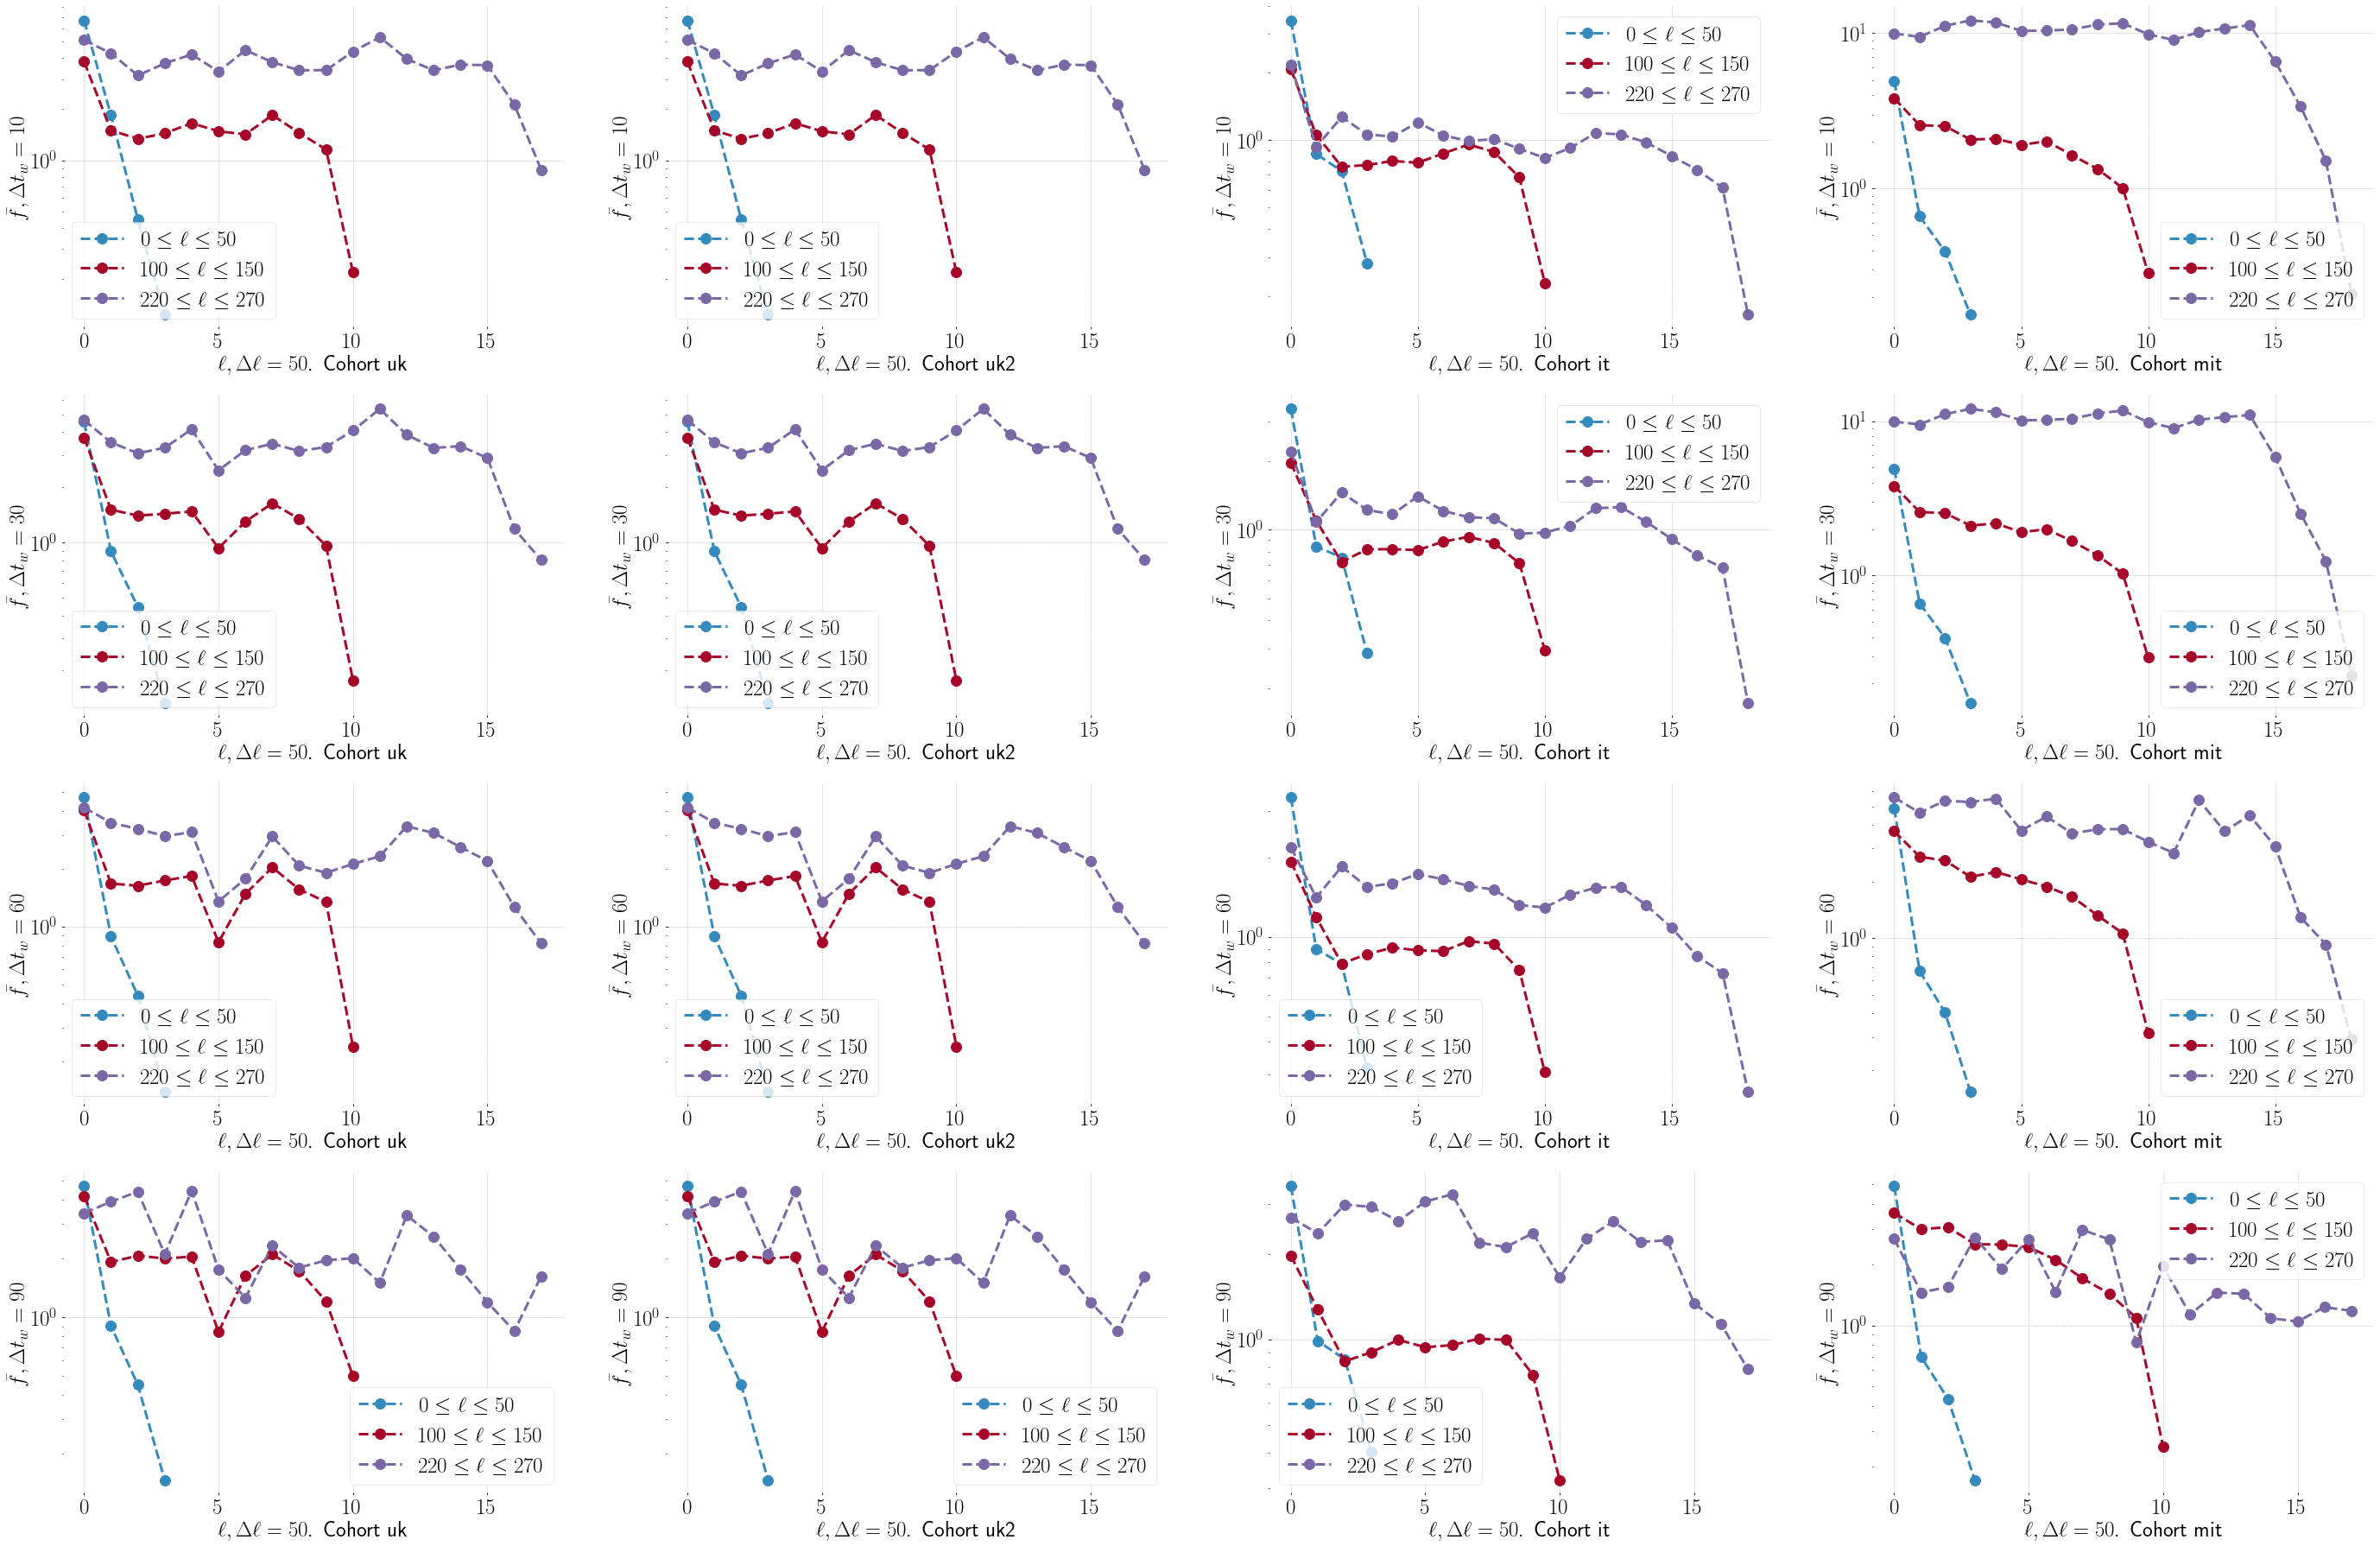

In [29]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Dt in S1['uk'].keys():
    for c in S1.keys():
        plt.subplot(5, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[lamb][0]}\leq \ell \leq {limits[lamb][1]}$')
        plt.legend()
        p += 1

In [30]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

## Different values for $\Delta \ell$

In [31]:
limits

[(0, 50), (100, 150), (220, 270)]

In [32]:
lims = {}
for i in range(3):
    lims[i] = [limits[i]] + [(limits[i][0], limits[i][0] + Dl) for Dl in [10, 30, 70, 90]]
        
lims

{0: [(0, 50), (0, 10), (0, 30), (0, 70), (0, 90)],
 1: [(100, 150), (100, 110), (100, 130), (100, 170), (100, 190)],
 2: [(220, 270), (220, 230), (220, 250), (220, 290), (220, 310)]}

In [33]:
S2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            S2[c][i][j] = {'f': pc.get_avgfa(dfftw[c][60], livestw[c][60], lims[i][j][0], lims[i][j][1])}

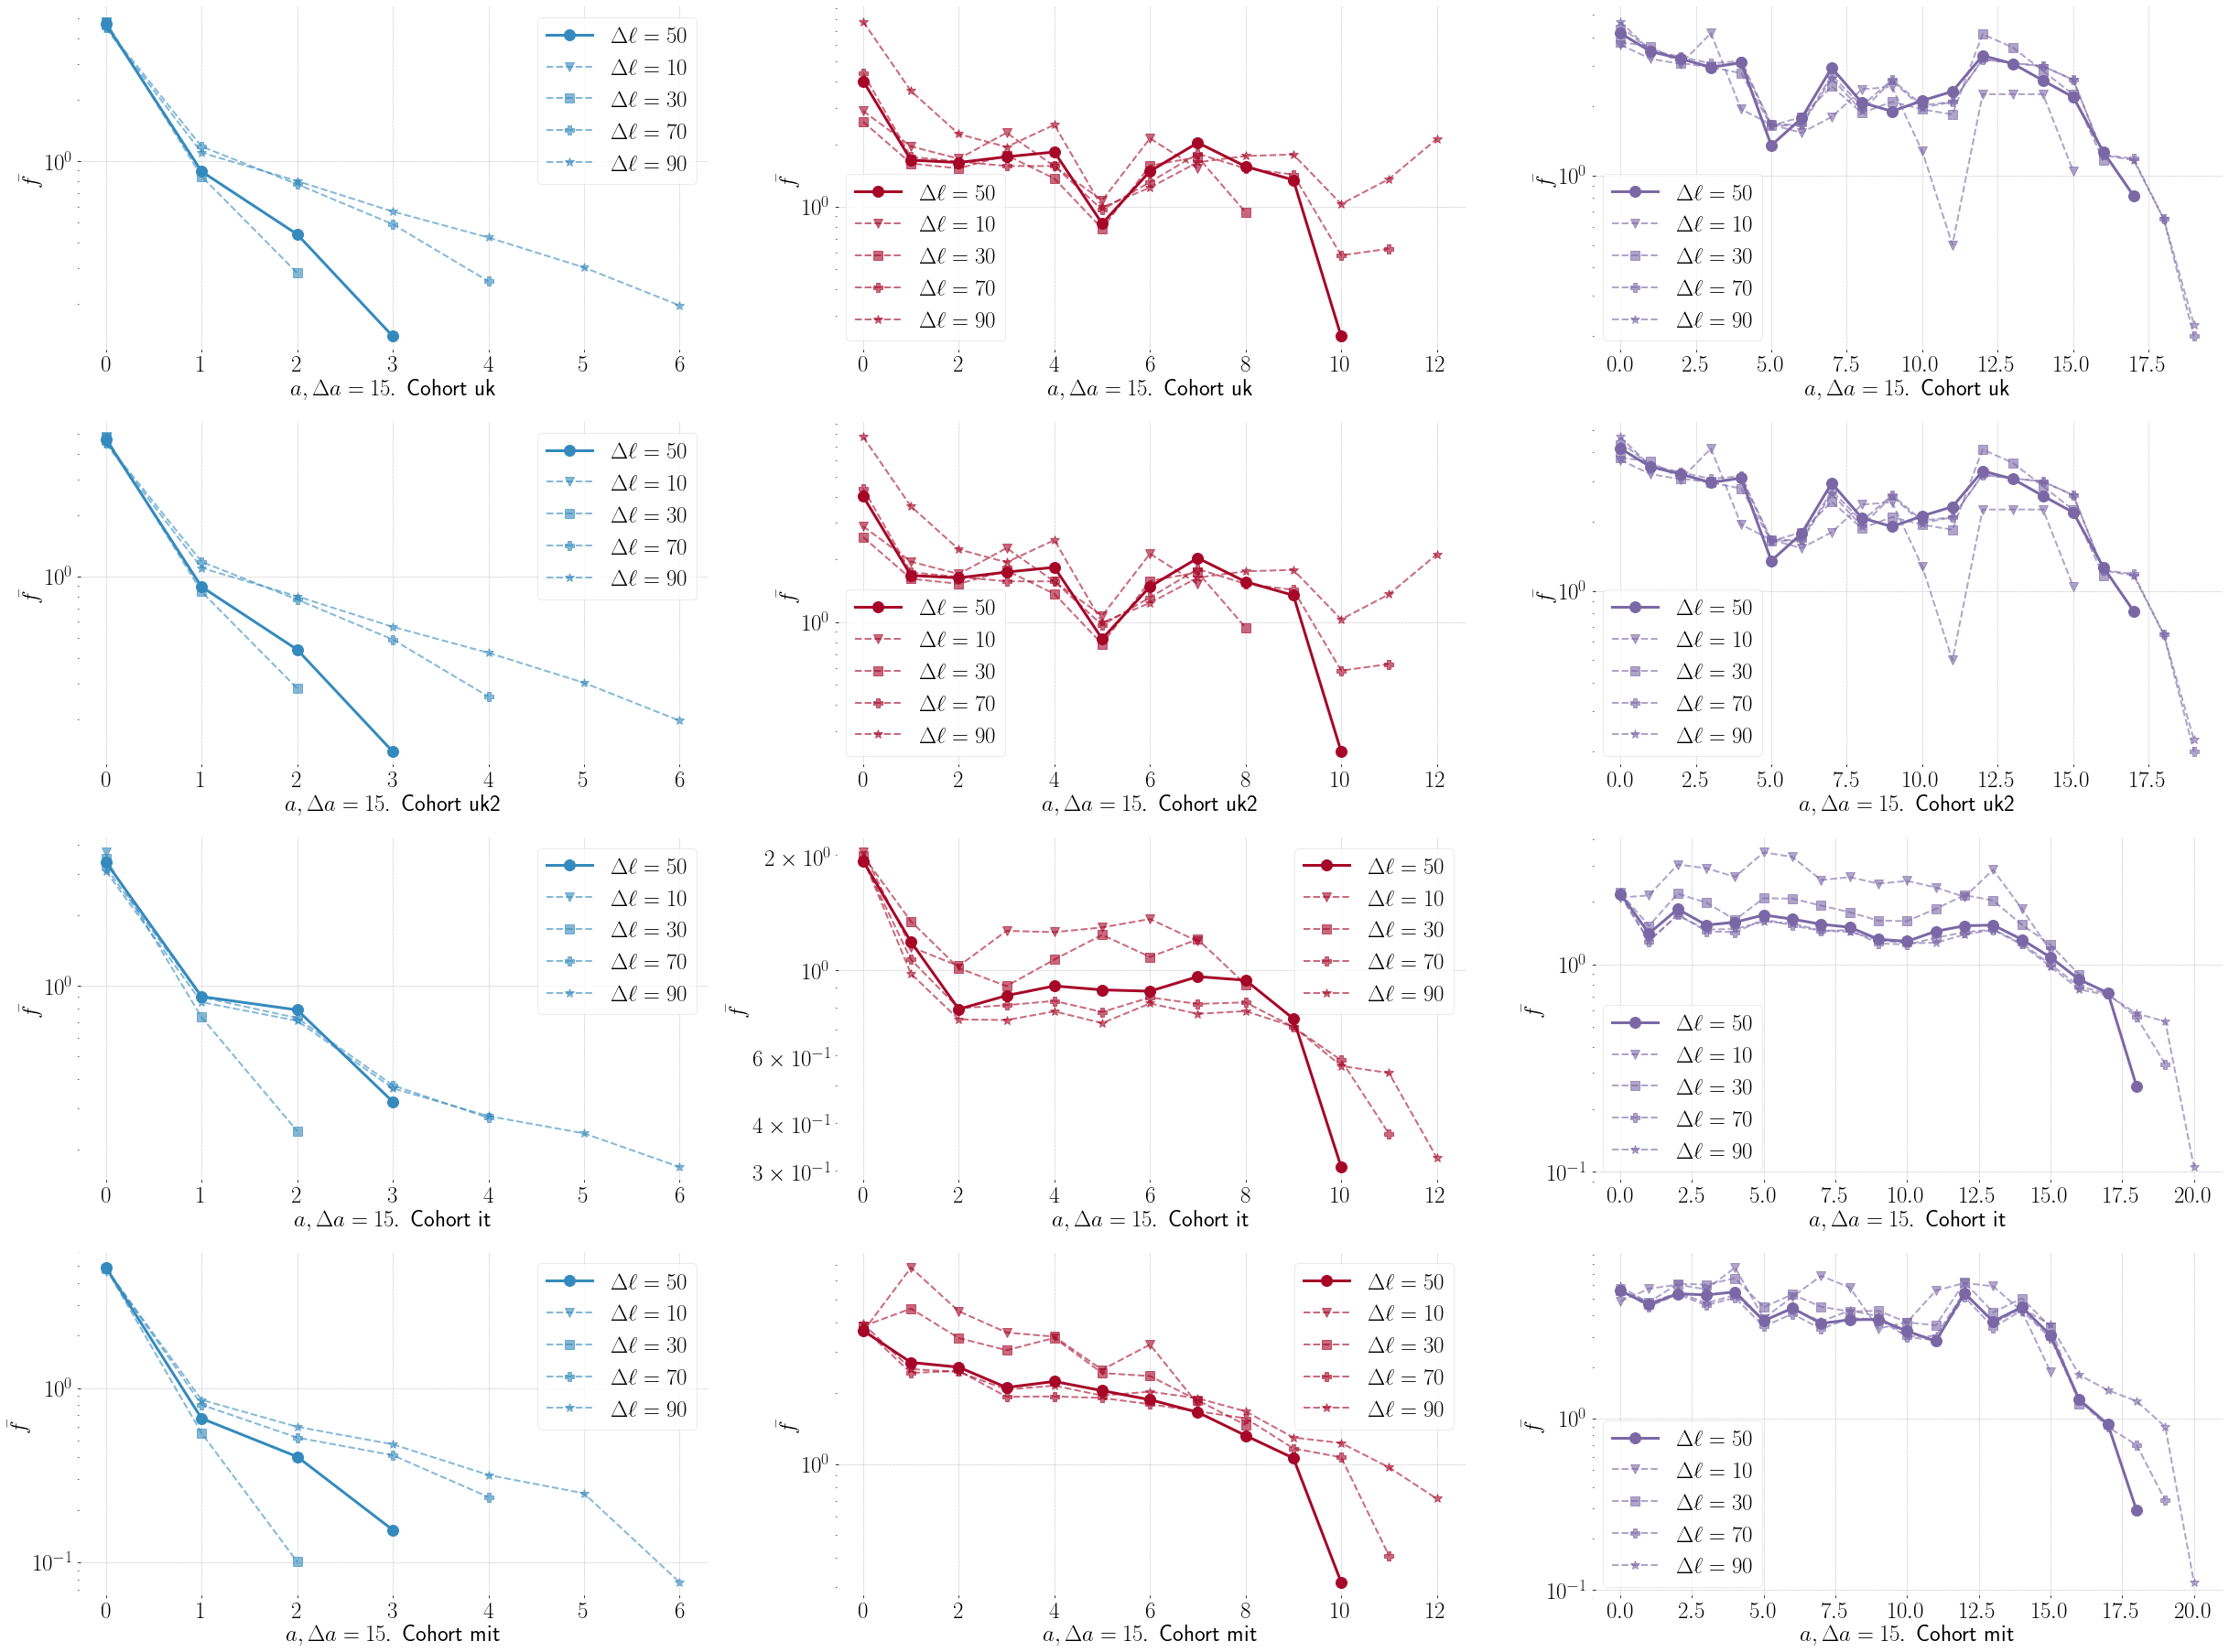

In [34]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [35]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## Fig 1: variations of $\Delta a$

In [36]:
dffDa = {}
dffDa['uk'] = {}
forkey = {'uk1': 'a', 'uk2': 'b'}
for c in ['uk1', 'uk2']:
    dffDa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        ddf = pc.get_f(calls[c], 'all', Da, 10)
        dffDa[c][Da] = {}
        dffDa['uk'][Da] = {}
        for ego in ddf.keys():
            dffDa[c][Da][f'{forkey[c]}{ego}'] = {}
            for alter in ddf[ego].keys():
                df1 = ddf[ego][alter]
                df2 = df1.loc[(df1['alpha'] <= 300 // Da)]
                dffDa[c][Da][f'{forkey[c]}{ego}'][alter] = df2
                dffDa['uk'][Da][f'{forkey[c]}{ego}'] = dffDa['uk'][Da].get(f'{forkey[c]}{ego}', {})
                dffDa['uk'][Da][f'{forkey[c]}{ego}'][alter] = dffDa['uk'][Da][f'{forkey[c]}{ego}'].get(alter, df2)
            
dffDa['mit'] = {}
for Da in [5, 10, 15, 30, 45]:
    dffDa['mit'][Da] = pc.get_f(calls['mit'], 'all', Da, 10)

In [37]:
Deltaa = {}
for c in ['uk', 'uk2', 'mit']:
    Deltaa[c] = {}
    for Da in [5, 10, 15, 30, 45]:
        Deltaa[c][Da] = {}
        for i in range(3):
            if c != 'it':
                Deltaa[c][Da][i] = pc.get_avgfa(dffDa[c][Da], lives[c], limits[i][0], limits[i][1])

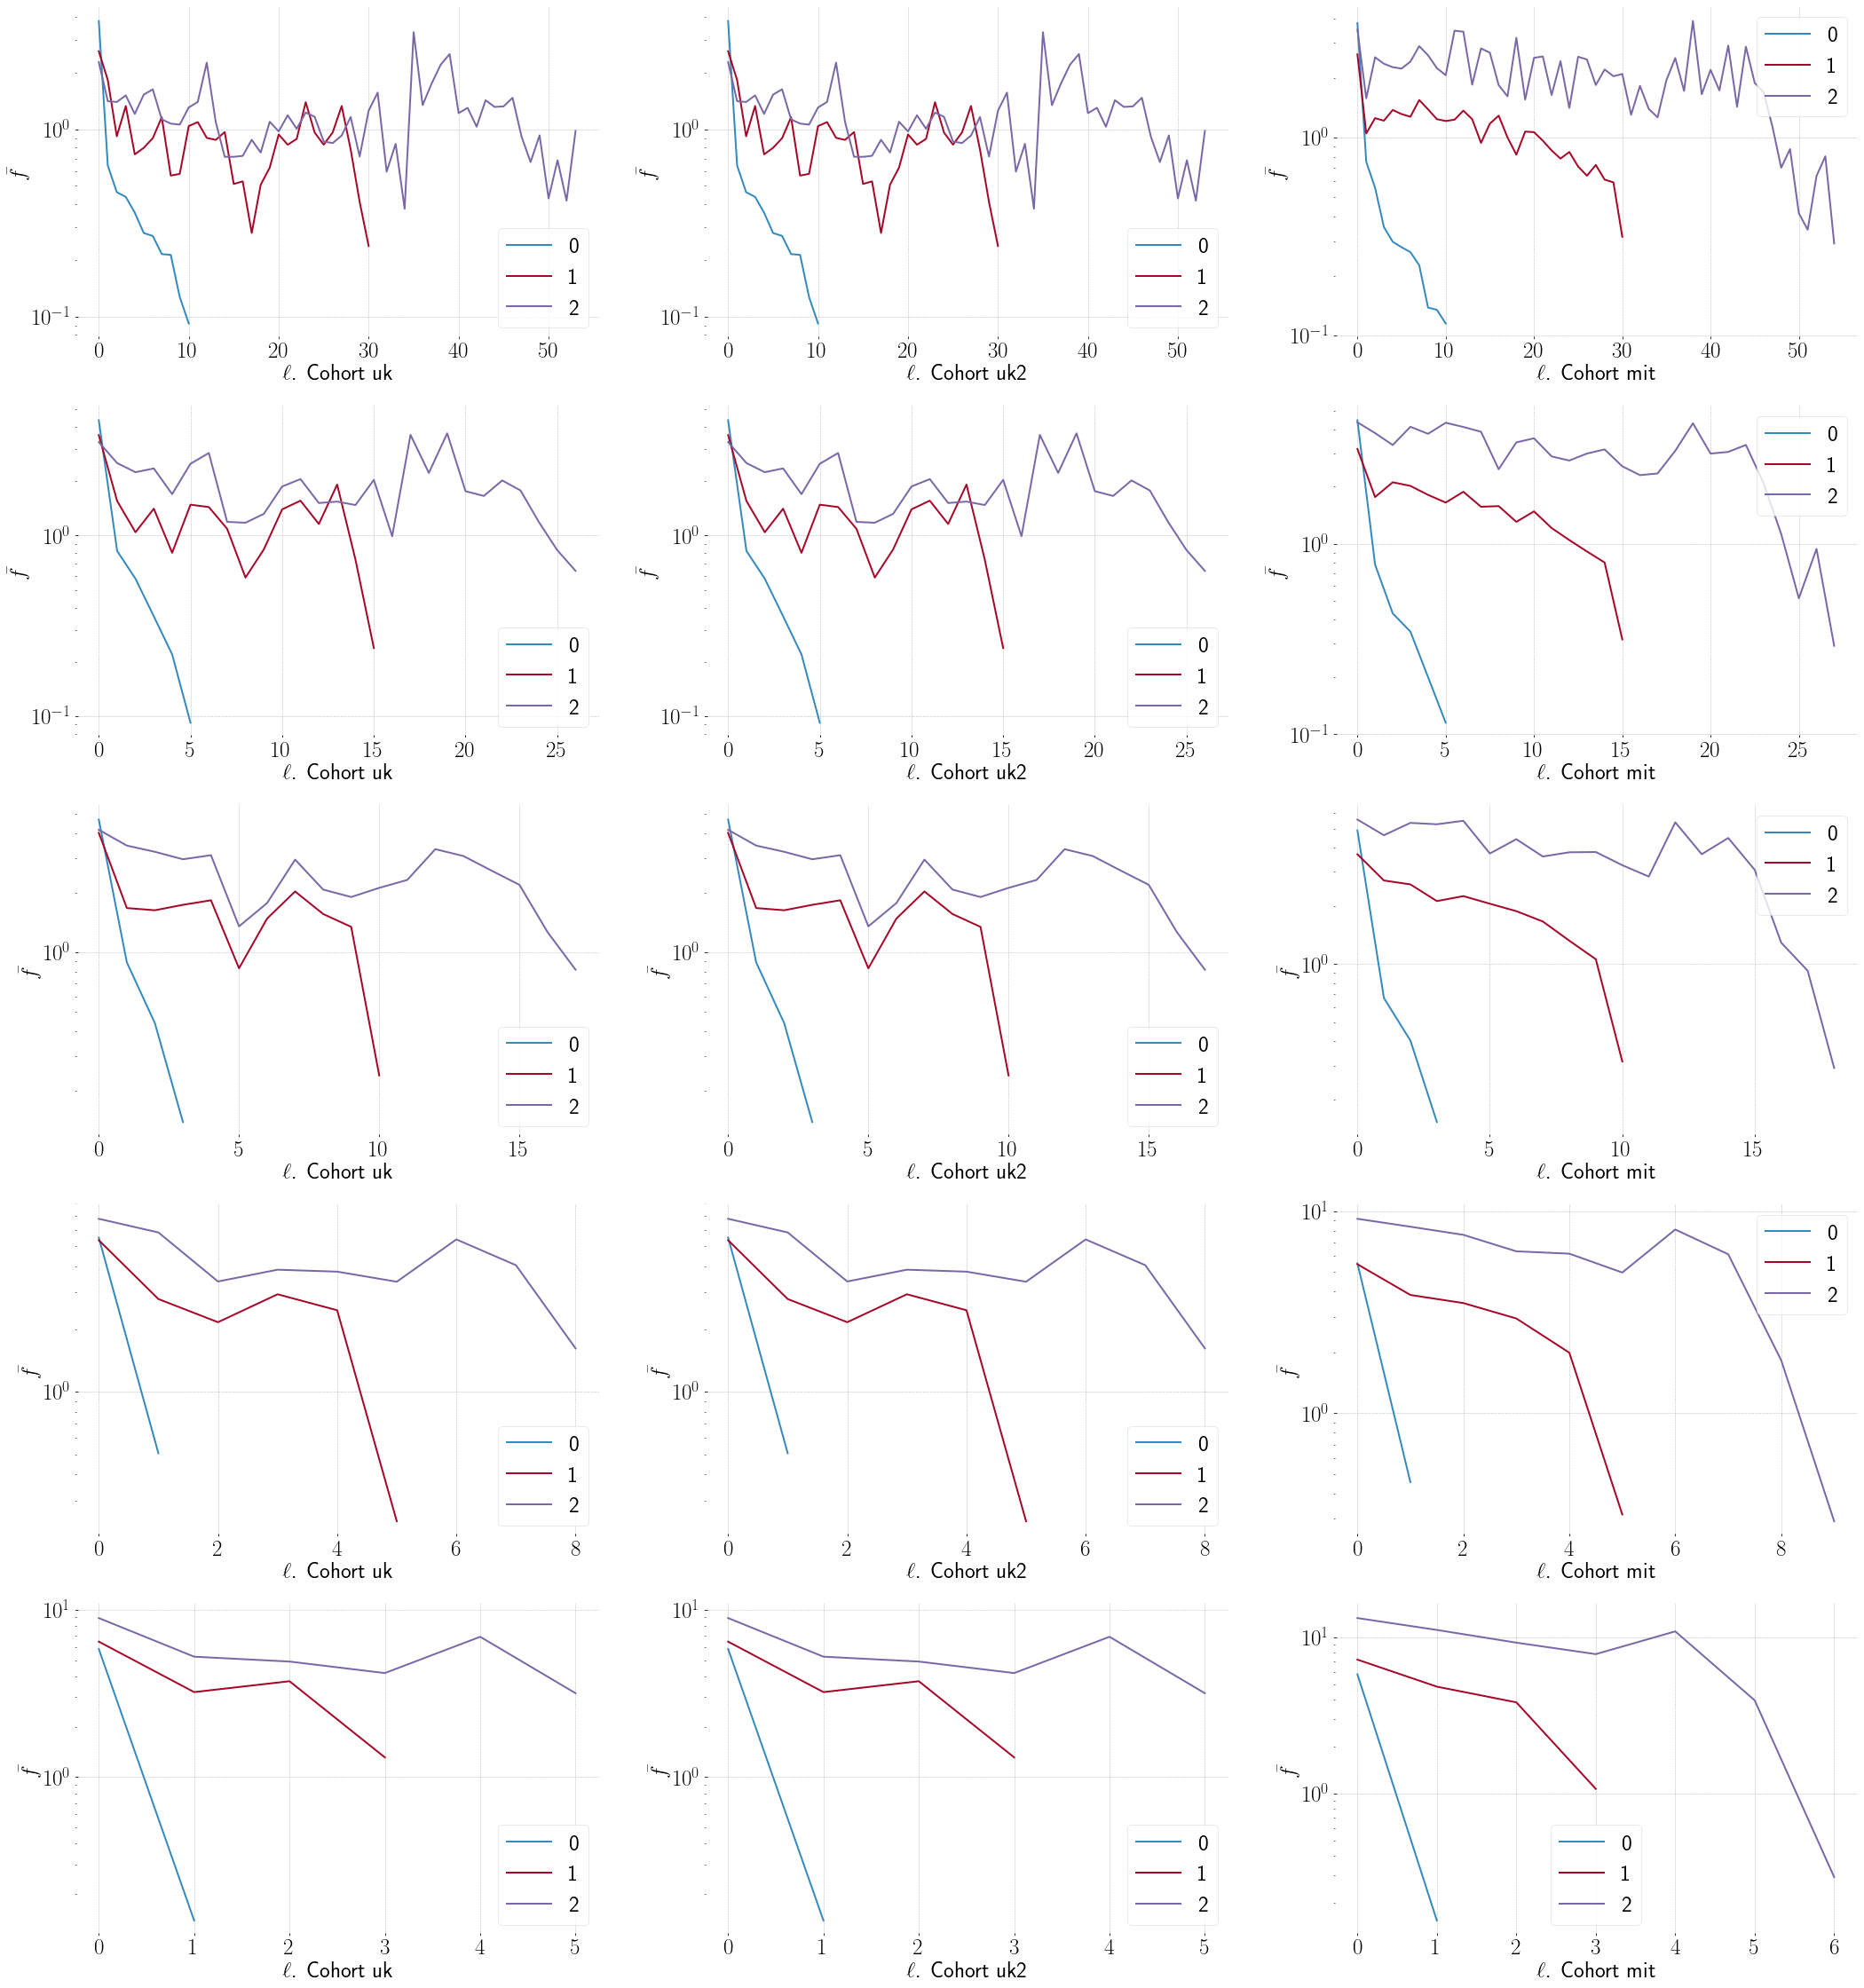

In [38]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in [5, 10, 15, 30, 45]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(fr'$\ell$. Cohort {c}')
        plt.ylabel(r'$\bar{f}$')
        plt.semilogy()
        for i in range(3):
            plt.plot(Deltaa[c][Da][i].index, Deltaa[c][Da][i]['f'], label=f'{i}')
        plt.legend()
        p += 1

In [39]:
tmp = pd.DataFrame(index=range(60))
for c in Deltaa.keys():
    for Da in Deltaa[c].keys():
        for i in range(3):
            df = Deltaa[c][Da][i]
            df.index *= Da
            df = df.reset_index()
            if c != 'uk2':
                df.columns = [f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'{c}D{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            else:
                df.columns = [f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}x{i}', f'ukbD{dict({5:"a", 10:"b", 15:"c", 30:"d", 45:"e"})[Da]}y{i}']
                tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')

# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S2.5.dat", index=False, sep="\t", header=True)

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

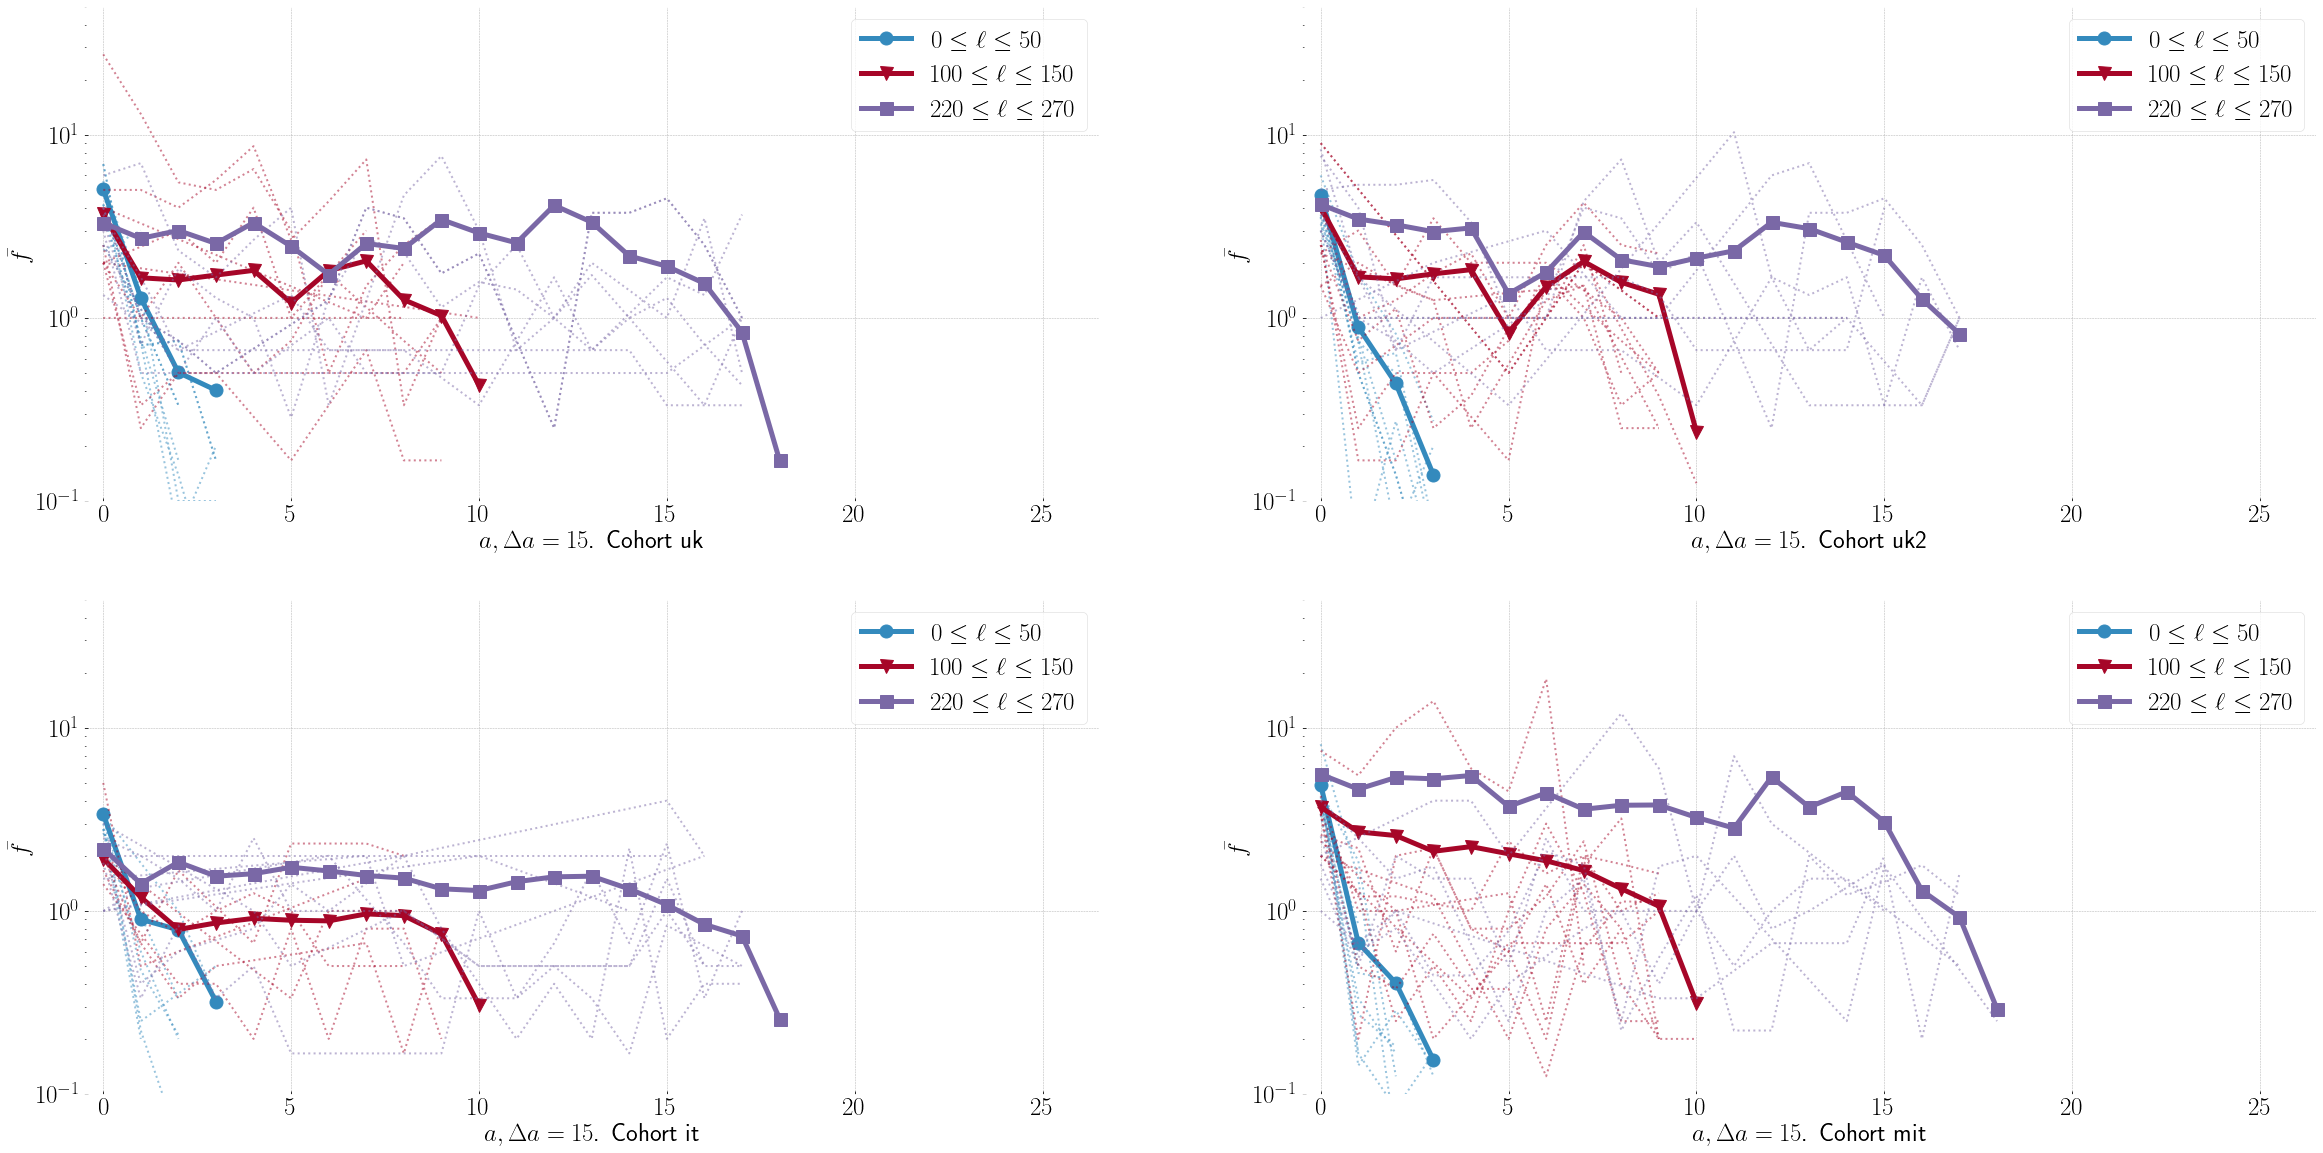

In [40]:
np.random.seed(9)
tmp = pd.DataFrame(index=range(25))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [41]:
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

## $b(\ell)$ by cohort

Only when it converges. I may try to  bin the values of $b$ to make it smoother. Also, I will calculate the same measurement considering a combined cohort.

In [42]:
dffcomb['all'] = {}
for c in ['uk1', 'uk2', 'it1', 'it2', 'mit']:
    dffcomb['all'].update(dffcomb[c])

In [43]:
t0 = dt.datetime.now()
b = {}
b2 = {}
converge = {}
converge2 = {}
nalt = {}
nego = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit', 'all']:
    b[c] = {}
    b2[c] = {}
    converge[c] = {}
    converge2[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(271):
        curve = pc.get_avgfa(dffcomb[c], lives[c], ell, ell + 50, countalt=True)
        if len(curve[0]) > 2:
            points = pc.get_b_slopes(curve[0], FlagConverge=True)
            points2 = pc.get_b_mk(curve[0], FlagConverge=True)
            b[c][ell] = points[1][1]
            b2[c][ell] = points2[1][1]
            converge[c][ell] = points[2]
            converge2[c][ell] = points2[2]
            nalt[c][ell] = curve[1]
            nego[c][ell] = curve[2]
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
    tmpb2 = pd.DataFrame.from_dict(b2[c], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
    tmpc2 = pd.DataFrame.from_dict(converge2[c], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmpb2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmpc2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['mas'] = b[c]['slopes'].rolling(window=50).mean()
    b[c]['mam'] = b[c]['mk'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:42.025204


In [44]:
for c in b.keys():
    print(c, b[c]['convs'].mean())

uk 0.7269372693726938
uk1 0.8191881918819188
uk2 0.5719557195571956
it 0.7933579335793358
it1 0.8560885608856088
it2 0.8081180811808119
mit 0.6531365313653137
all 0.6346863468634686


In [45]:
nea = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'it1', 'it2', 'mit']:
    tmp = dffcomb[c]
    n = 0
    for ego in tmp.keys():
        for alter in tmp[ego].keys():
            n += 1
    nea[c] = n
    
nea

{'uk': 1944,
 'uk1': 1000,
 'uk2': 944,
 'it': 4371,
 'it1': 1400,
 'it2': 2971,
 'mit': 4311}

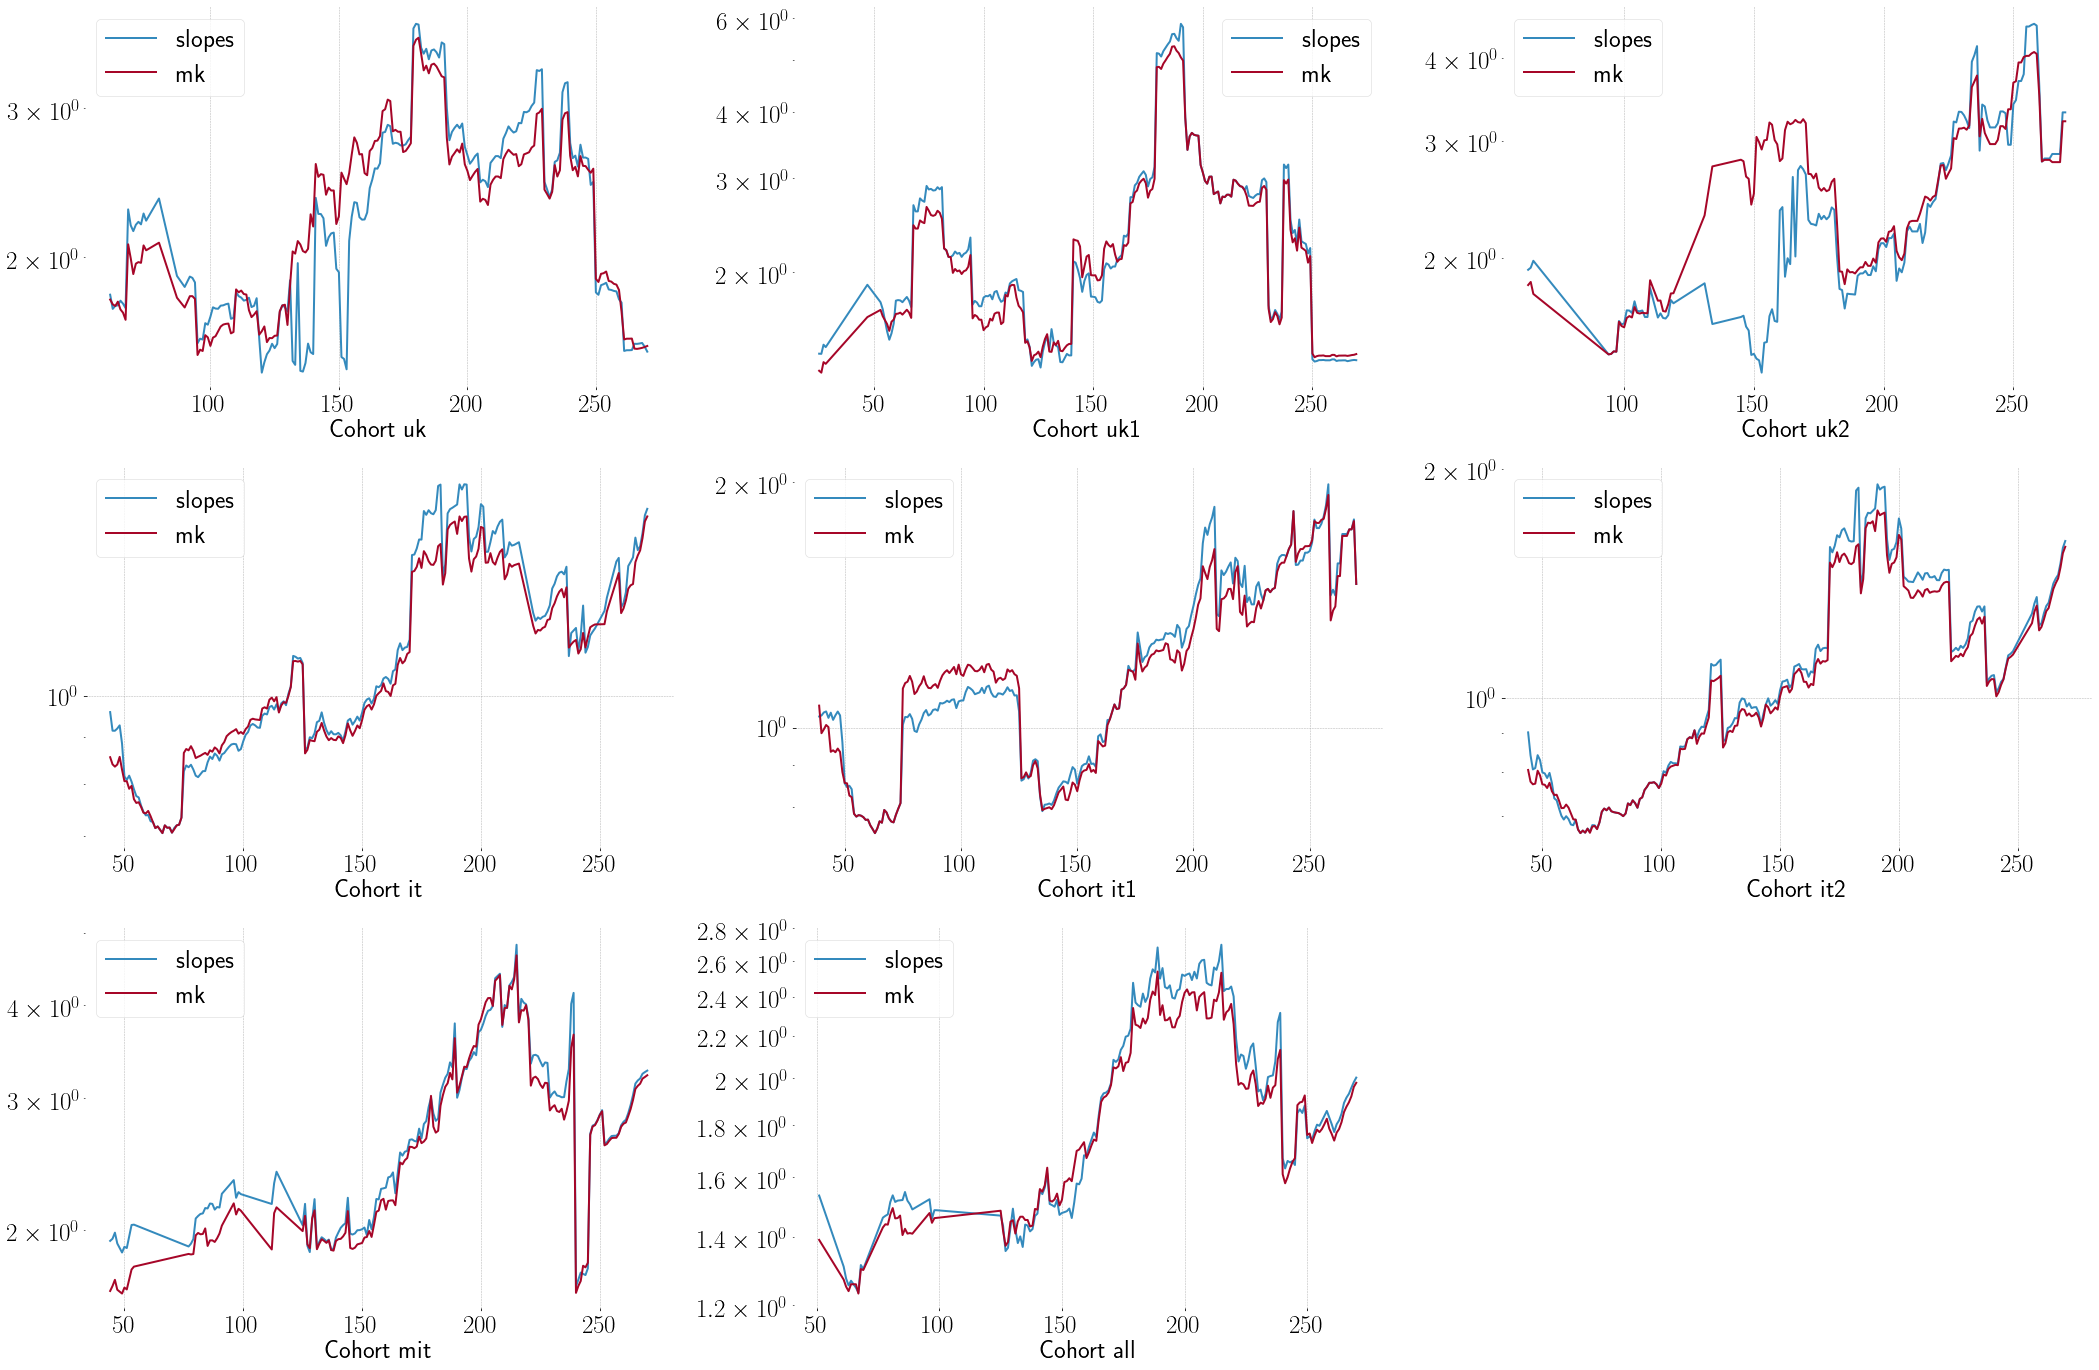

In [47]:
plt.figure(figsize=(12*3, 8*3))
p = 1
for c in b.keys():
    plt.subplot(3,3,p)
    df = b[c].loc[b[c]['convs'] == True]
    plt.semilogy()
    plt.xlabel(f'Cohort {c}')
    plt.plot(df.index, df['slopes'], label="slopes")
    plt.plot(df.index, df['mk'], label='mk')
    plt.legend()
    p += 1

In [48]:
binsize = 50
bbins = {}
for c in b.keys():
    df = b[c].loc[b[c]['convs'] == True]
    df2 = df[['slopes', 'mk']].copy()
    df2['lambda'] = df.index.map(lambda x: x // binsize)
    bbins[c] = df2.groupby('lambda').mean()
    bbins[c]['x'] = bbins[c].index.map(lambda x: (x * binsize) + (binsize // 2))

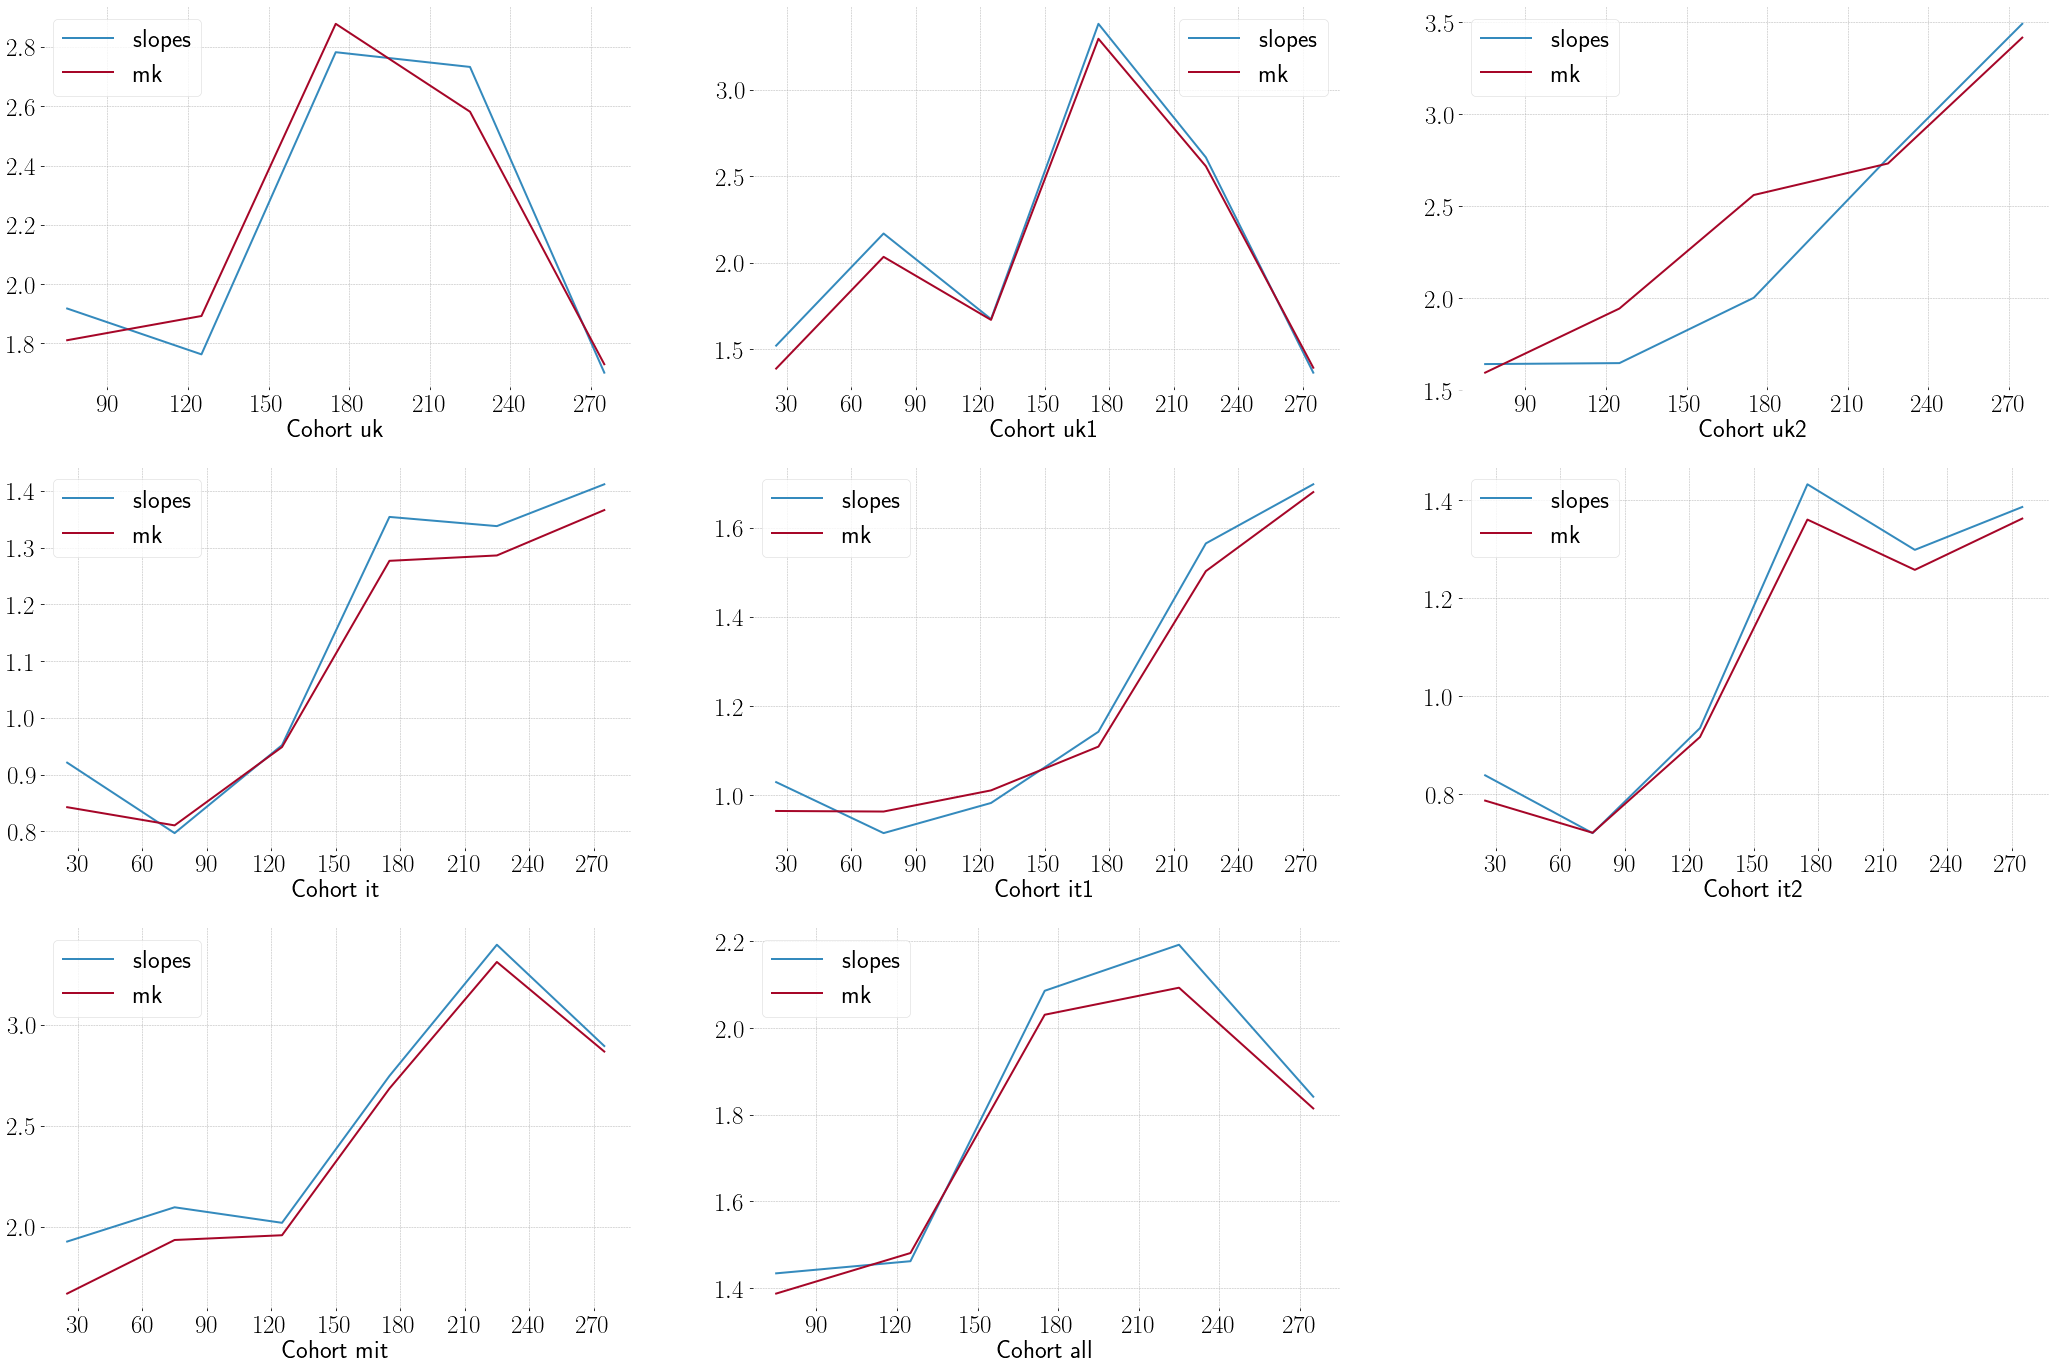

In [49]:
plt.figure(figsize=(12*3, 8*3))
p = 1
for c in bbins.keys():
    plt.subplot(3,3,p)
    df = bbins[c]
    #plt.semilogy()
    plt.xticks(range(0, 291, 30))
    plt.xlabel(f'Cohort {c}')
    plt.plot(df['x'], df['slopes'], label="slopes")
    plt.plot(df['x'], df['mk'], label='mk')
    plt.legend()
    p += 1

In [50]:
tmp = pd.DataFrame()
for c in bbins.keys():
    df = bbins[c].copy(deep=True)
    df.columns = [f's{c}', f'm{c}', f'x{c}']
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S4.dat", index=False, header=True, sep="\t")

In [51]:
tmp

suk       muk    xuk      suk1      muk1  xuk1      suk2  \
lambda                                                                  
0            nan       nan    nan  1.521471  1.388855    25       nan   
1       1.917691  1.810808   75.0  2.169592  2.034713    75  1.641424   
2       1.763119   1.89248  125.0  1.674952  1.670341   125  1.646674   
3       2.782129  2.877841  175.0  3.381680  3.295272   175  2.001913   
4       2.732448  2.581432  225.0  2.609830  2.558561   225  2.762282   
5       1.701422  1.729856  275.0  1.365273  1.393897   275  3.492192   

            muk2   xuk2       sit  ...  xit1      sit2      mit2  xit2  \
lambda                             ...                                   
0            nan    nan  0.921197  ...    25  0.838798  0.787180    25   
1       1.594775   75.0  0.797083  ...    75  0.720851  0.721547    75   
2        1.94357  125.0  0.951975  ...   125  0.935192  0.916970   125   
3       2.560944  175.0  1.353889  ...   175  1.432620  1.360601   175   
4       2.732477  225.0  1.337697  ...   225  1.298822  1.258013   225   
5       3.417161  275.0  1.411367  ...   275  1.386295  1.362655   275   

            smit      mmit  xmit      sall      mall   xall  
lambda                                                       
0       1.928010  1.670676    25       nan       nan    nan  
1       2.097423  1.935704    75  1.433968  1.387264   75.0  
2       2.020659  1.959193   125  1.461954  1.480815  125.0  
3       2.747107  2.684848   175  2.086029  2.030742  175.0  
4       3.395848  3.310657   225   2.19227  2.093116  225.0  
5       2.894935  2.867621   275  1.841607   1.81449  275.0  

[6 rows x 24 columns]

## Distribution of $b_i(\ell)$

In [52]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i))
    return df

In [53]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.4598086124401914, 0.01) (0.4598086124401914, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.0455974842767295, 0.01) (1.0455974842767295, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(0.9791206525900402, 0.01) (0.9791206525900402, 1)};
=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.5570247933884297, 0.01) (0.5570247933884297, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.011904761904762, 0.01) (1.011904761904762, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.2555137170521786, 0.01) (0.2555137170521786, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.39790502793296095, 0.01) (0.397905027

In [54]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5.dat", index=False, header=True, sep="\t")

### Now using mann kendall

In [66]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [68]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 5, log=False)
        H['tmp'] = H['h'] * H['label']
        avg = sum(H['tmp']) / sum(H['h'])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.01) ({avg}, 1)}};")
        H = H[['pmf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S5b.dat", index=False, header=True, sep="\t")

=====================uk========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.697603305785124, 0.01) (0.697603305785124, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.0218915343915342, 0.01) (1.0218915343915342, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1295009157509157, 0.01) (1.1295009157509157, 1)};
=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.678517316017316, 0.01) (0.678517316017316, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9802721088435373, 0.01) (0.9802721088435373, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.775213675213675, 0.01) (1.775213675213675, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.23114083983649206, 0.01) (0.23114083983649206, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.39548802946593, 0.01) (0.395488029465

## $p$-value distribution for the KS test

In [69]:
ksp = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

============	UK	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.79937106918239, 0.04) (0.79937106918239, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7182251082251081, 0.04) (0.7182251082251081, 1)};
============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8125850340136055, 0.04) (0.8125850340136055, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.6950757575757575, 0.04) (0.6950757575757575, 1)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8717877094972067, 0.04) (0.8717877094972067, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8157111164697373, 0.04) (0.8157111164697373, 1)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.7817754262198706, 0.04) (0.7817754262198706, 1)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7439429618001047, 0.04) (0.7439429618001047, 1)};


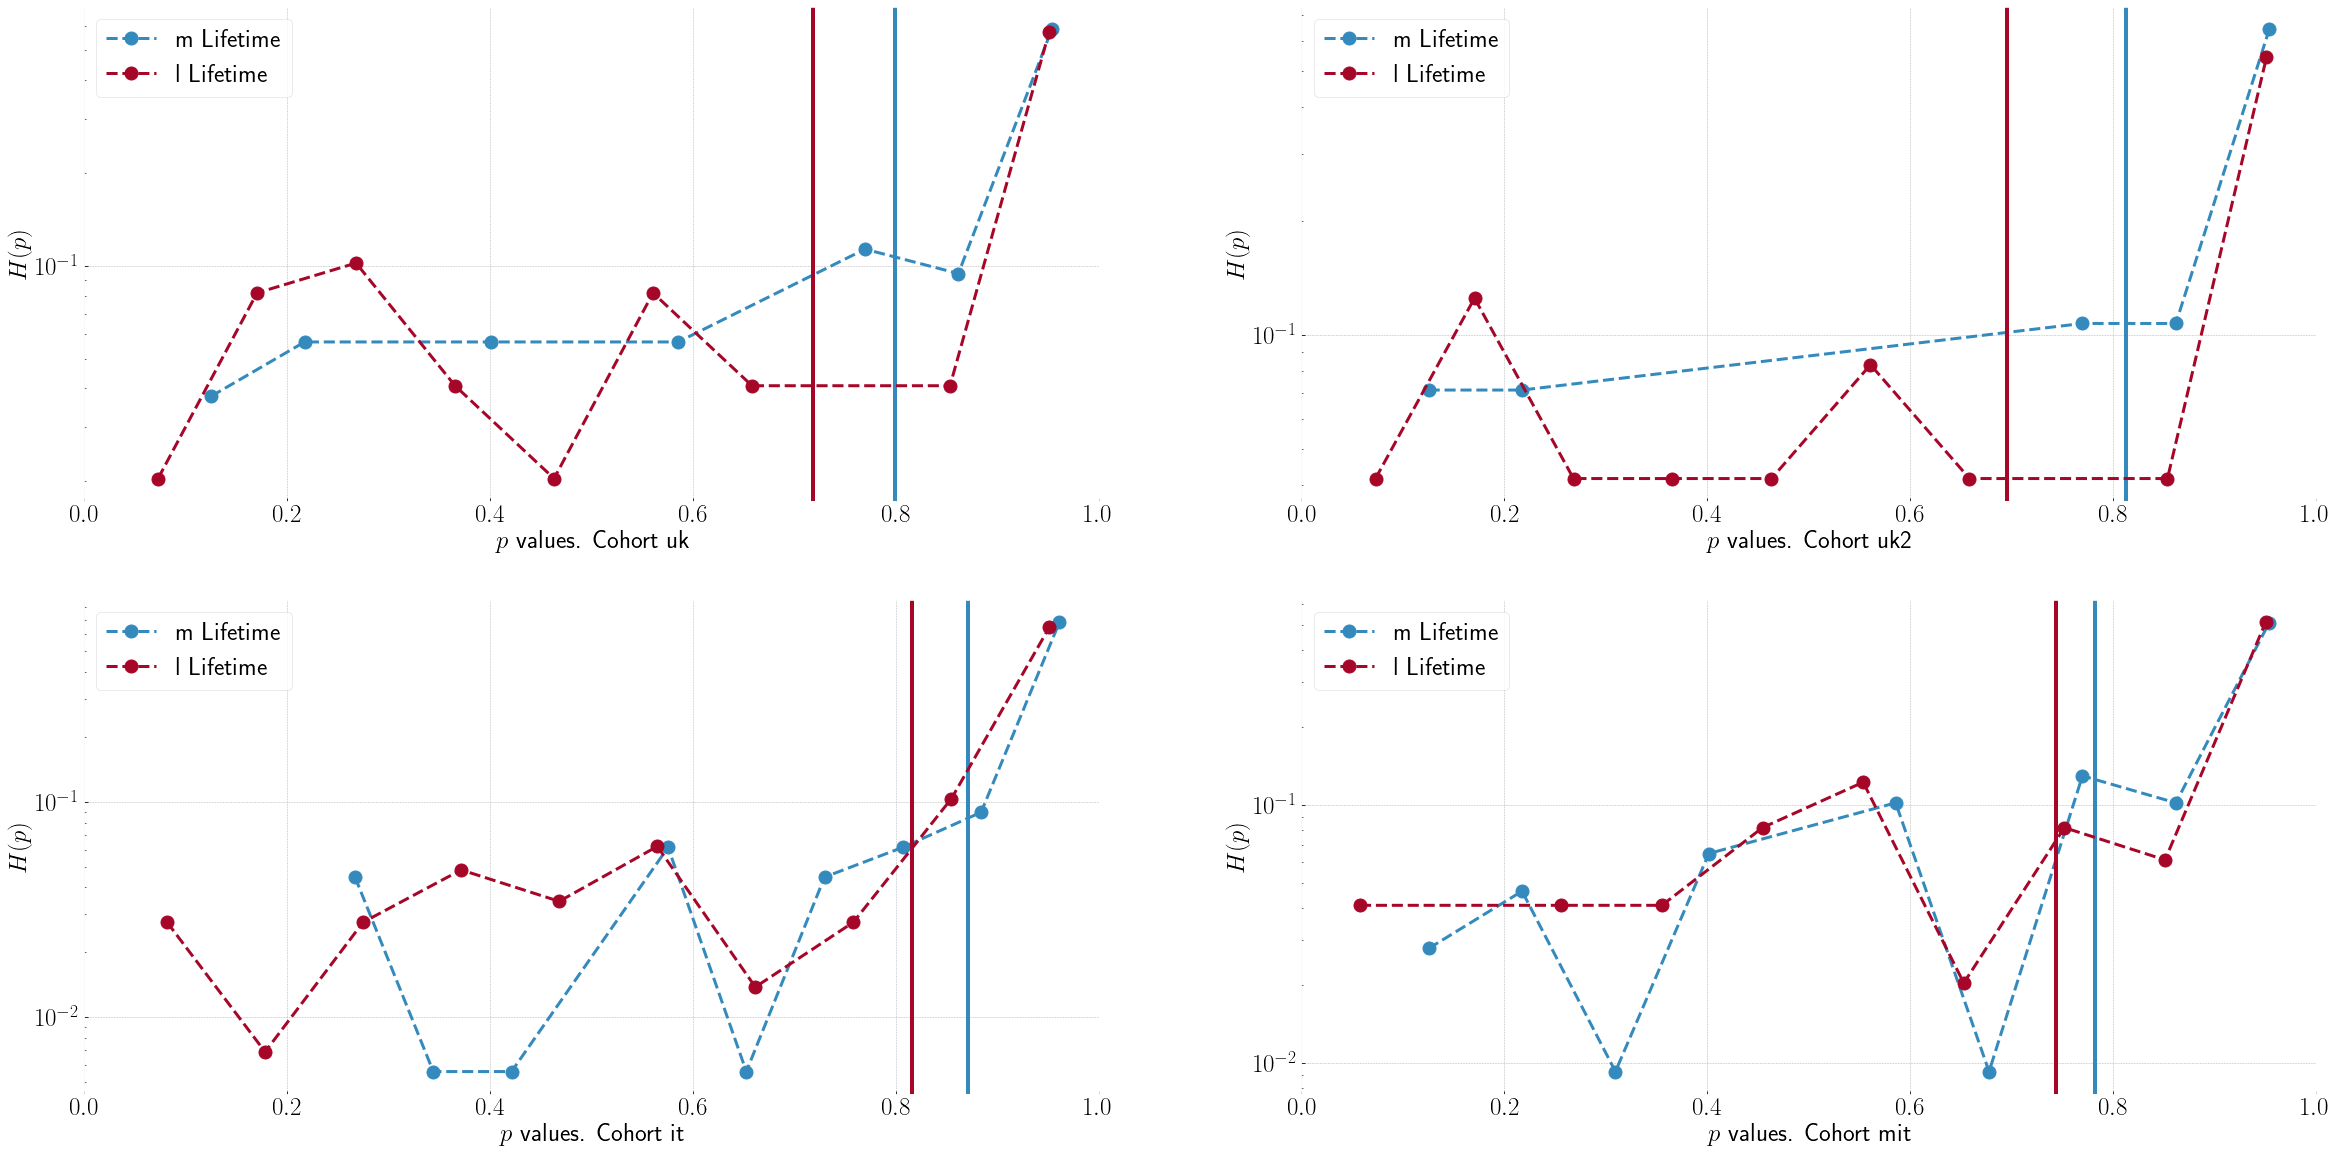

In [70]:
tmp = pd.DataFrame(index=range(10))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    plt.subplot(2, 2, p)
    plt.semilogy()
    plt.xlim(0, 1)
    plt.xlabel(fr"$p$ values. Cohort {c}")
    plt.ylabel(r'$H(p)$')
    m = 0
    for s in ['m', 'l']:
        H = pc.histogram(ksp[c][s], 10, log=False)
        H['tmp'] = H['label'] * H['h']
        avg = sum(H['tmp']) / sum(H['h'])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pmf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.04) ({avg}, 1)}};')
        plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, c=colors[m], label=f"{s} Lifetime")
        plt.axvline(avg, ls="solid", lw=4, c=colors[m])
        m += 1
    plt.legend()
    p += 1

In [71]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S6.dat", index=False, header=True, sep="\t")

## Identify $\ell_s$ for each cohort



In [72]:
def get_ells(bdf, col, lookforward=15):
    df = bdf[[col]].rolling(lookforward).mean()
    df2 = df.loc[df[col] == 1]
    if len(df2) > 0:
        return min(df2.index)
    else:
        return None    

In [73]:
egolist = {}
for c in dffcomb.keys():
    egolist[c] = [ego for ego in dffcomb[c].keys()]

In [74]:
t0 = dt.datetime.now()
bi = {}
bi2 = {}
convergei = {}
convergei2 = {}
niter = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    bi[c] = {}
    bi2[c] = {}
    convergei[c] = {}
    convergei2[c] = {}
    niter[c] = {}
    for ego in egolist[c]:
        bi[c][ego] = {}
        bi2[c][ego] = {}
        convergei[c][ego] = {}
        convergei2[c][ego] = {}
        niter[c][ego] = {}
        thisdf = {ego: dffcomb[c][ego]}
        for ell in range(271):
            curve = pc.get_avgfa(thisdf, lives[c], ell, ell + 50)
            if (curve is not None) and (len(curve) > 3):
                points = pc.get_b_slopes(curve, FlagConverge=True)
                points2 = pc.get_b_mk(curve, FlagConverge=True)
                bi[c][ego][ell] = points[1][1]
                bi2[c][ego][ell] = points2[1][1]
                convergei[c][ego][ell] = points[2]
                convergei2[c][ego][ell] = points2[2]
                niter[c][ego][ell] =  points2[3]
        if len(bi[c][ego].keys()) > 0:
            bi[c][ego] = pd.DataFrame.from_dict(bi[c][ego], orient='index').sort_index().rename({0: 'slopes'}, axis='columns')
            tmp = pd.DataFrame.from_dict(convergei[c][ego], orient="index").sort_index().rename({0: 'convs'}, axis='columns')
            if ego in bi2[c].keys():
                tmpb2 = pd.DataFrame.from_dict(bi2[c][ego], orient='index').sort_index().rename({0: 'mk'}, axis='columns')
                tmpc2 = pd.DataFrame.from_dict(convergei2[c][ego], orient="index").sort_index().rename({0: 'convm'}, axis='columns')
            bi[c][ego] = bi[c][ego].merge(tmp, left_index=True, right_index=True, how='outer')
            if ego in bi2[c].keys():
                bi[c][ego] = bi[c][ego].merge(tmpb2, left_index=True, right_index=True, how='outer')
                bi[c][ego] = bi[c][ego].merge(tmpc2, left_index=True, right_index=True, how='outer')
                bi[c][ego]['mam'] = bi[c][ego]['mk'].rolling(window=50).mean()
            bi[c][ego]['mas'] = bi[c][ego]['slopes'].rolling(window=50).mean()
            
print(f'Took {dt.datetime.now() - t0}')

Took 0:08:16.801689


In [75]:
type(bi['uk']['aC07974937643'])

pandas.core.frame.DataFrame

In [76]:
for ego in bi['mit'].keys():
    if type(bi['mit'][ego]) == pd.core.frame.DataFrame:
        print(np.mean(bi['mit'][ego]['convm']))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [104]:
bif = {}
bif['all'] = {}
for c in bi.keys():
    bif[c] = {}
    for ego in bi[c].keys():
        if type(bi[c][ego]) == pd.core.frame.DataFrame:
            bif[c][ego] = bi[c][ego]
            bif['all'].update(bif[c])

In [110]:
for c in ['uk', 'uk2', 'it', 'mit']:
    for ego in bif[c].keys():
        if ego not in bif['all'].keys():
            print('problem with', c, ego)
    else:
        print('success!', c)

success! uk
success! uk2
success! it
success! mit


In [111]:
ellsHs = {}
for c in bif.keys():
    ellsHs[c] = pc.histogram([get_ells(bif[c][ego], 'convs') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convs') is not None], 10, log=False)

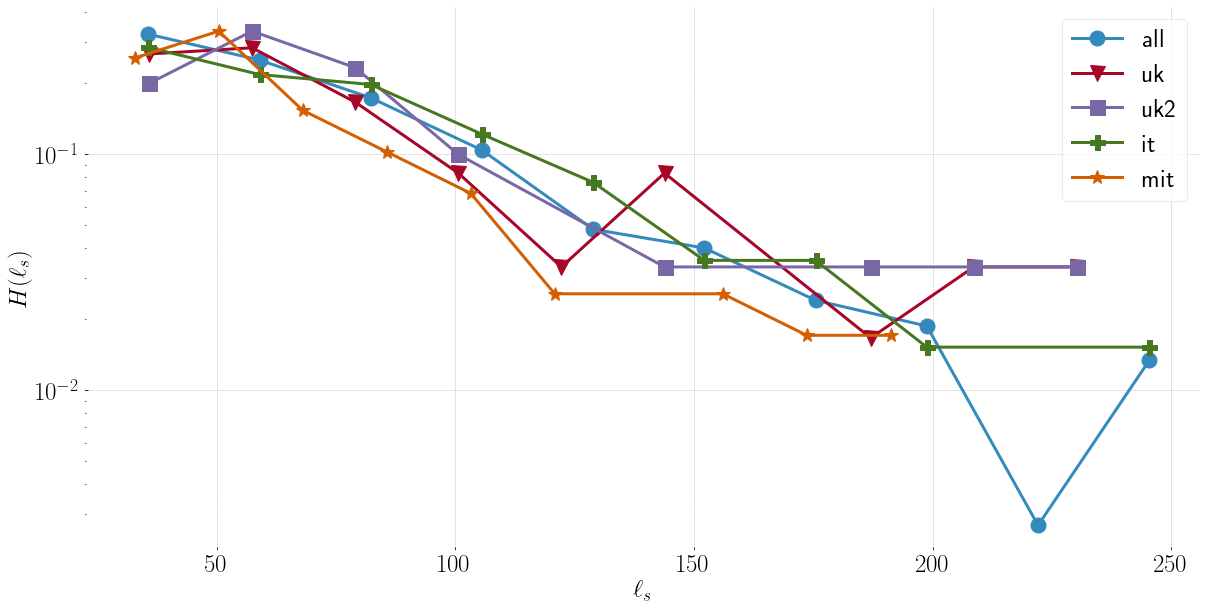

In [112]:
plt.semilogy()
plt.xlabel(r'$\ell_s$')
plt.ylabel(r'$H(\ell_s)$')
m = 0
for c in ellsHs.keys():
    plt.plot(ellsHs[c]['label'], ellsHs[c]['pmf'], marker=markers[m], ls="solid", markersize=15, lw=3, label=f'{c}')
    m += 1
plt.legend()

In [80]:
ellsHm = {}
for c in bif.keys():
    listells = [get_ells(bif[c][ego], 'convm') for ego in bif[c].keys() if get_ells(bif[c][ego], 'convm') is not None]
    if len(listells) > 0:
        ellsHm[c] = pc.histogram(listells, 10, log=False)

In [113]:
tmp = pd.DataFrame()
for c in ellsHs.keys():
    print(f'================{c}=====================')
    H = ellsHs[c].copy(deep=True)
    H['tmp'] = H['label'] * H['h']
    avg = sum(H['tmp']) / sum(H['h'])
    print(avg)
    H = H[['label', 'pmf']]
    H = H.rename({'label': f'x{c}', 'pmf': f'y{c}'}, axis='columns')
    tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S9.dat", index=False, header=True, sep="\t")

================all=====================
75.77085561497326
================uk=====================
81.16
================uk2=====================
80.44
================it=====================
80.35761421319796
================mit=====================
64.84102564102564


In [114]:
tmp

xall      yall    xuk       yuk   xuk2      yuk2     xit       yit  \
0   35.65  0.323529   35.8  0.266667   35.8       0.2   35.65  0.284264   
1   58.95  0.251337   57.4  0.283333   57.4  0.333333   58.95  0.218274   
2   82.25  0.173797   79.0  0.166667   79.0  0.233333   82.25   0.19797   
3  105.55  0.104278  100.6  0.083333  100.6       0.1  105.55  0.121827   
4  128.85  0.048128  122.2  0.033333    nan       nan  128.85  0.076142   
5  152.15  0.040107  143.8  0.083333  143.8  0.033333  152.15  0.035533   
6  175.45  0.024064    nan       nan    nan       nan  175.45  0.035533   
7  198.75  0.018717  187.0  0.016667  187.0  0.033333  198.75  0.015228   
8  222.05  0.002674  208.6  0.033333  208.6  0.033333     nan       nan   
9  245.35  0.013369  230.2  0.033333  230.2  0.033333  245.35  0.015228   

    xmit      ymit  
0   32.8   0.25641  
1   50.4  0.333333  
2   68.0  0.153846  
3   85.6  0.102564  
4  103.2  0.068376  
5  120.8  0.025641  
6    nan       nan  
7  156.0  0.025641  
8  173.6  0.017094  
9  191.2  0.017094

## Fig 3 separated by country

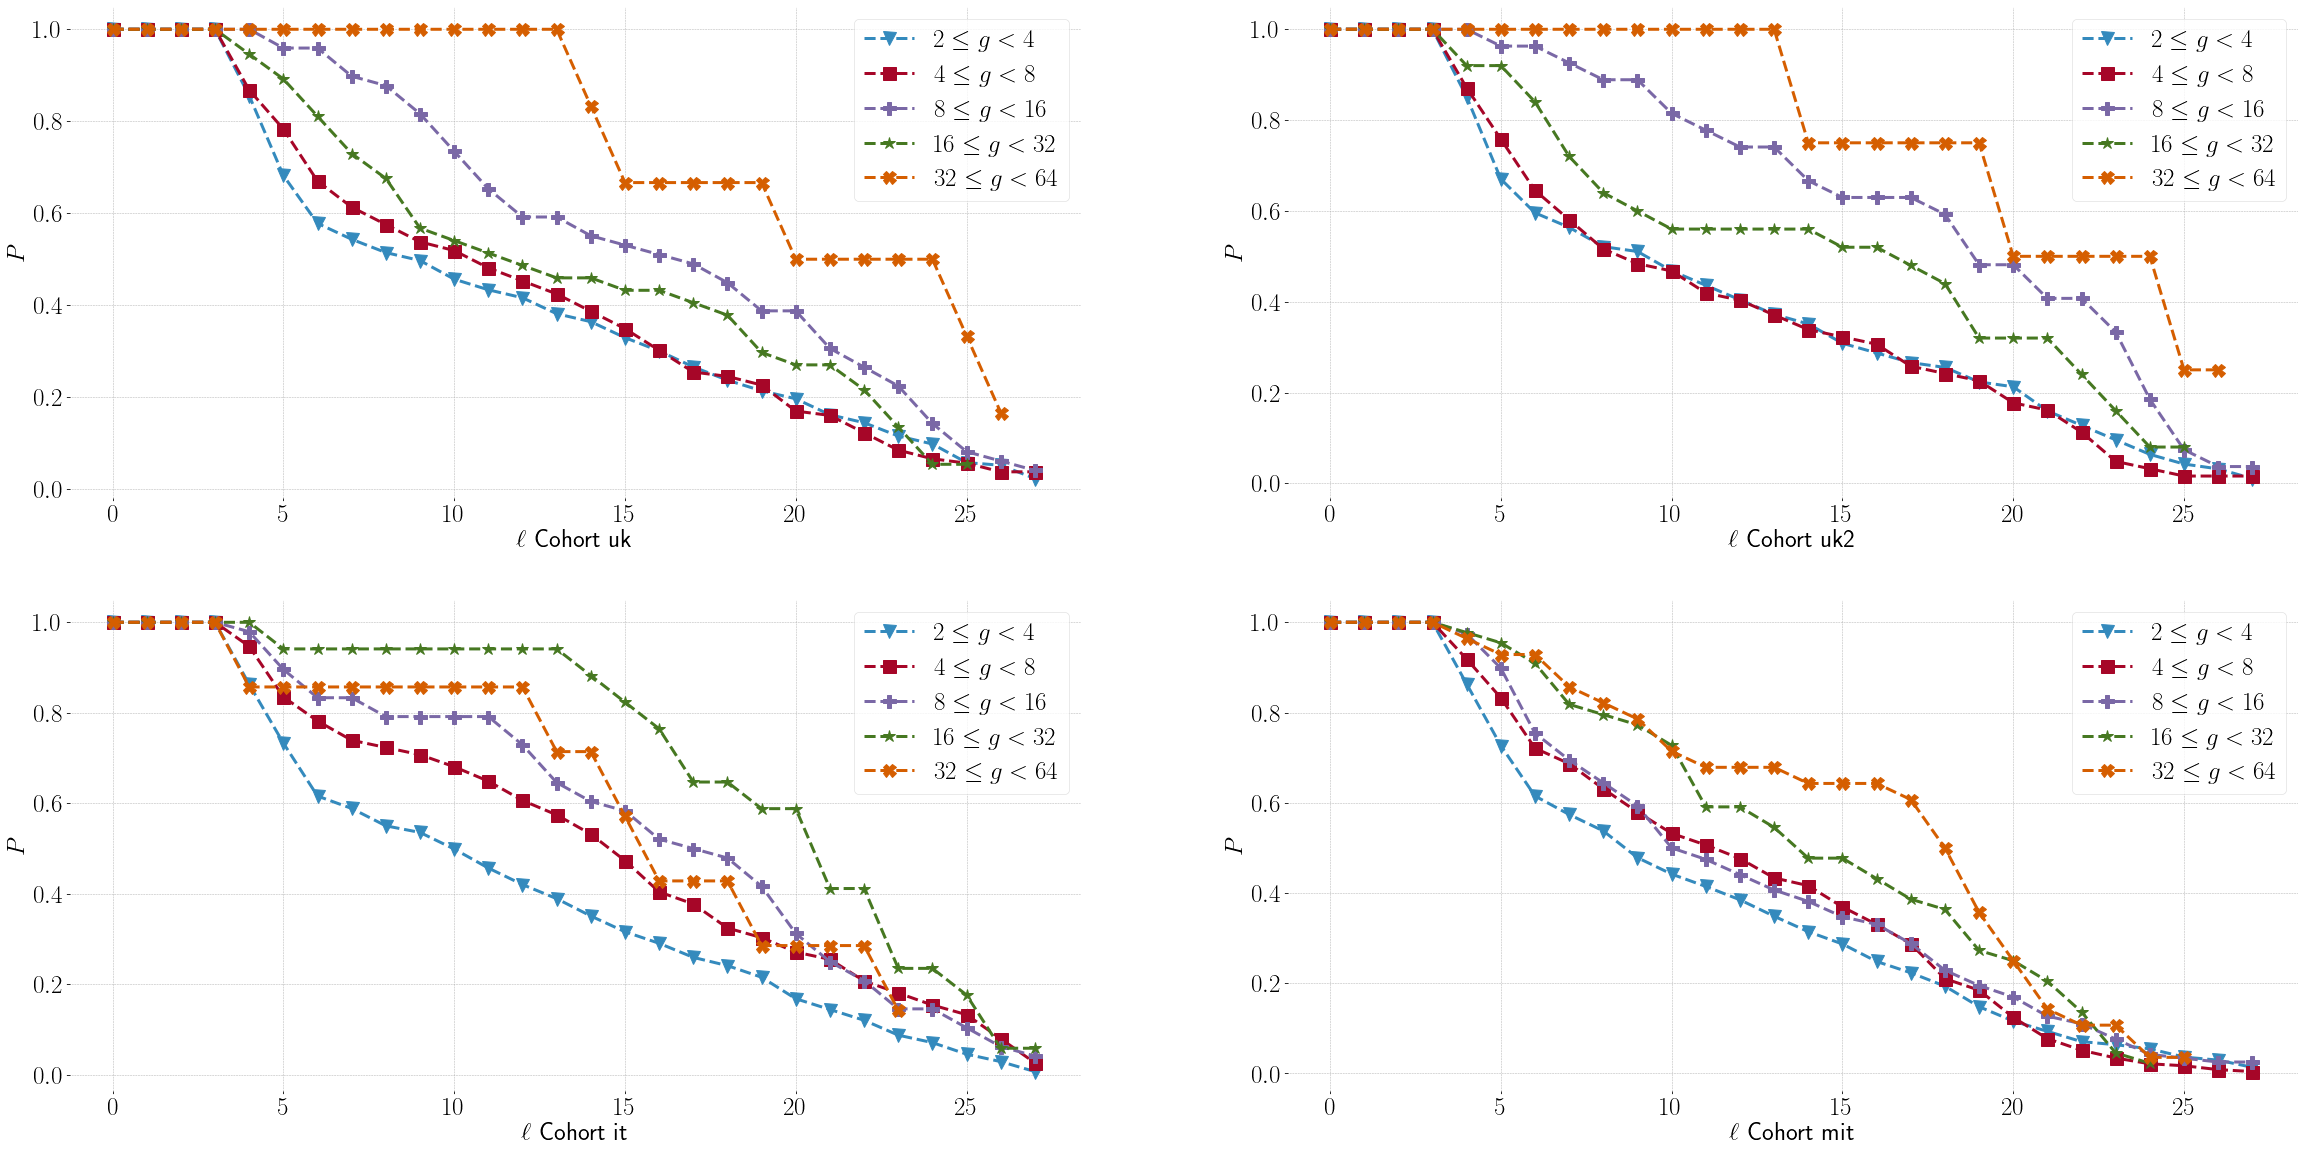

In [83]:
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(1,6):
        plt.plot(fig3[c][i].index, fig3[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
    plt.legend()
    p += 1

In [84]:
tmp = pd.DataFrame()
for c in ['uk', 'uk2', 'mit', 'it']:
    for i in range(1, 6):
        tmp[f'{c}{i}'] = fig3[c][i]
        
tmp.index = tmp.index * 10
tmp.index.rename('a', inplace=True)
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S7.dat", index=True, header=True, sep="\t")

In [85]:
tmp

uk1       uk2       uk3       uk4       uk5      uk21      uk22  \
a                                                                           
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
20   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
30   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
40   0.855491  0.867925  1.000000  0.945946  1.000000  0.851064  0.870968   
50   0.682081  0.783019  0.959184  0.891892  1.000000  0.670213  0.758065   
60   0.578035  0.669811  0.959184  0.810811  1.000000  0.595745  0.645161   
70   0.543353  0.613208  0.897959  0.729730  1.000000  0.563830  0.580645   
80   0.514451  0.575472  0.877551  0.675676  1.000000  0.521277  0.516129   
90   0.497110  0.537736  0.816327  0.567568  1.000000  0.510638  0.483871   
100  0.456647  0.518868  0.734694  0.540541  1.000000  0.468085  0.467742   
110  0.433526  0.481132  0.653061  0.513514  1.000000  0.436170  0.419355   
120  0.416185  0.452830  0.591837  0.486486  1.000000  0.404255  0.403226   
130  0.381503  0.424528  0.591837  0.459459  1.000000  0.372340  0.370968   
140  0.364162  0.386792  0.551020  0.459459  0.833333  0.351064  0.338710   
150  0.329480  0.349057  0.530612  0.432432  0.666667  0.308511  0.322581   
160  0.300578  0.301887  0.510204  0.432432  0.666667  0.287234  0.306452   
170  0.265896  0.254717  0.489796  0.405405  0.666667  0.265957  0.258065   
180  0.236994  0.245283  0.448980  0.378378  0.666667  0.255319  0.241935   
190  0.213873  0.226415  0.387755  0.297297  0.666667  0.223404  0.225806   
200  0.196532  0.169811  0.387755  0.270270  0.500000  0.212766  0.177419   
210  0.161850  0.160377  0.306122  0.270270  0.500000  0.159574  0.161290   
220  0.144509  0.122642  0.265306  0.216216  0.500000  0.127660  0.112903   
230  0.115607  0.084906  0.224490  0.135135  0.500000  0.095745  0.048387   
240  0.098266  0.066038  0.142857  0.054054  0.500000  0.063830  0.032258   
250  0.057803  0.056604  0.081633  0.054054  0.333333  0.042553  0.016129   
260  0.052023  0.037736  0.061224       NaN  0.166667  0.031915  0.016129   
270  0.023121  0.037736  0.040816       NaN       NaN  0.010638  0.016129   

         uk23  uk24  uk25      mit1      mit2      mit3      mit4      mit5  \
a                                                                             
0    1.000000  1.00  1.00  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.000000  1.00  1.00  1.000000  1.000000  1.000000  1.000000  1.000000   
20   1.000000  1.00  1.00  1.000000  1.000000  1.000000  1.000000  1.000000   
30   1.000000  1.00  1.00  1.000000  1.000000  1.000000  1.000000  1.000000   
40   1.000000  0.92  1.00  0.863326  0.918455  0.974576  0.977273  0.964286   
50   0.962963  0.92  1.00  0.726651  0.832618  0.898305  0.954545  0.928571   
60   0.962963  0.84  1.00  0.615034  0.721030  0.754237  0.909091  0.928571   
70   0.925926  0.72  1.00  0.574032  0.686695  0.694915  0.818182  0.857143   
80   0.888889  0.64  1.00  0.537585  0.630901  0.644068  0.795455  0.821429   
90   0.888889  0.60  1.00  0.478360  0.579399  0.593220  0.772727  0.785714   
100  0.814815  0.56  1.00  0.441913  0.532189  0.500000  0.727273  0.714286   
110  0.777778  0.56  1.00  0.414579  0.506438  0.474576  0.590909  0.678571   
120  0.740741  0.56  1.00  0.384966  0.476395  0.440678  0.590909  0.678571   
130  0.740741  0.56  1.00  0.348519  0.433476  0.406780  0.545455  0.678571   
140  0.666667  0.56  0.75  0.314351  0.416309  0.381356  0.477273  0.642857   
150  0.629630  0.52  0.75  0.287016  0.369099  0.347458  0.477273  0.642857   
160  0.629630  0.52  0.75  0.248292  0.330472  0.330508  0.431818  0.642857   
170  0.629630  0.48  0.75  0.223235  0.287554  0.288136  0.386364  0.607143   
180  0.592593  0.44  0.75  0.193622  0.210300  0.228814  0.363636  0.500000   
190  0.481481  0.32  0.75  0.148064  0.1

## Distribution of $g$

In [86]:
dffsurv.keys()

dict_keys(['all', 'it', 'uk', 'uk2', 'mit'])

In [115]:
gcount = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    gcount[c] = {}
    for ego in dffsurv[c].keys():
        for alter in dffsurv[c][ego].keys():
            tmp = dffsurv[c][ego][alter]
            tmp2 = tmp.loc[(tmp['alpha'] >= 2) & (tmp['alpha'] <= 3)]
            tmp3 = tmp.loc[tmp['alpha'] <= 20]
            if len(tmp2) > 0:
                ncalls = sum(tmp2['f'])
                gcount[c]['sample'] = gcount[c].get('sample', [])
                gcount[c]['sample'].append(ncalls)
            if len(tmp3) > 0:
                ncalls = sum(tmp3['f'])
                gcount[c]['all'] = gcount[c].get('all', [])
                gcount[c]['all'].append(ncalls)

In [124]:
ghist = {}
for c in gcount.keys():
    ghist[c] = {}
    for s in gcount[c].keys():
        ghist[c][s] = pc.histogram(gcount[c][s], 10, log=True)

In [126]:
ghist['uk2']['sample']

h       pmf       label
0.0  95  0.302548    1.000000
1.0  60  0.191083    1.689064
2.0  56  0.178344    2.852938
3.0  47  0.149682    4.818796
4.0  16  0.050955    8.139256
5.0  20  0.063694   13.747727
6.0  14  0.044586   23.220795
7.0   3  0.009554   39.221415
8.0   1  0.003185   66.247492
9.0   2  0.006369  111.896274

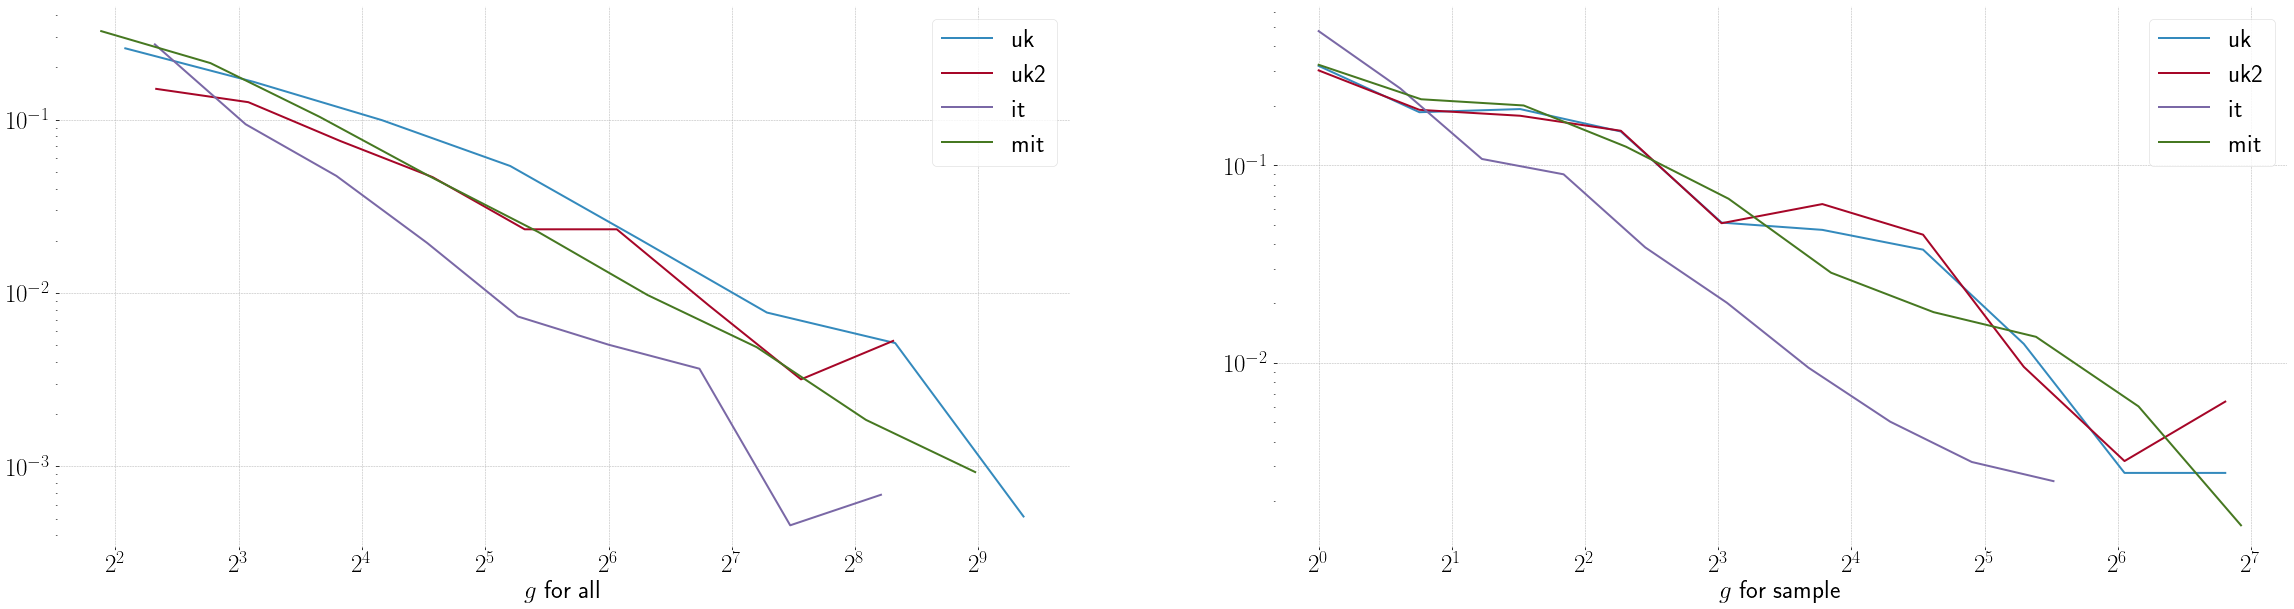

In [134]:
tmp = pd.DataFrame()
plt.figure(figsize=(20*2, 10*1))
p = 1
for s in ['all', 'sample']:
    plt.subplot(1,2,p)
    plt.xscale("log", base=2)
    plt.yscale("log")
    plt.xlabel(fr'$g$ for {s}')
    for c in ghist.keys():
        df = ghist[c][s]
        if s == 'all':
            df = df.loc[df['label'] > 3]
        df2 = df[['pmf', 'label']]
        df2.columns = [f'p{dict({"all": "a", "sample": "s"})[s]}{c}', f'x{dict({"all": "a", "sample": "s"})[s]}{c}']
        tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
        plt.plot(df['label'], df['pmf'], label=c)
    plt.legend()
    p += 1
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S10.dat", index=False, header=True, sep="\t")

## Fig 2 using Mann Kendall Estimation

In [92]:
cols = {1: 'm', 2: 'l'}
tmp = pd.DataFrame(index=range(111))
lists = []
for c in bhist2.keys():
    for ell in [1, 2]:
        thelist = bhist2[c][ell]
        for i in range(len(thelist)):
            tmp.at[i, f'{c}{cols[ell]}'] = thelist[i]
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/figs/fig2downb.dat", index=False, header=True, sep="\t")

In [93]:
cols = ['ukm', 'uk2m', 'itm', 'mitm', 'ukl', 'uk2l', 'itl', 'mitl']
pos = [0,3,6,9,1,4,7,10]
tmp2 = pd.DataFrame({'c': cols, 'pos': pos})
idx = list(tmp2.index)
for i in idx:
    mean = np.mean(tmp[cols[i]].dropna())
    sem = np.std(tmp[cols[i]].dropna())
    tmp2.at[i, 'mean'] = mean
    tmp2.at[i, 'sem'] = sem
tmp2.index.name = 'idx'
a = tmp2.loc[tmp2.index < 4]
b = tmp2.loc[tmp2.index >= 4]
# a.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bmdownb.dat", index=True, header=True, sep="\t")
# b.to_csv("../commpatterns/PNAS_paper/SI/figs/fig2bldownb.dat", index=True, header=True, sep="\t")

## Variation on fig4

In [94]:
dffUI = {}
for c in ['uk', 'it']:
    dffUI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffUI, alphafixed=(2,3), externalell=lives['all'], lambdamax=27)

In [95]:
surv_cont.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [96]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4ac.dat", header=False, index=False, sep="\t")

In [97]:
points_mit = pc.get_survival(dffsurv['mit'], unbinned=True, lambdamax=27, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_mit.keys():
    if s <= 2**5 + 1:
        df = points_mit[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4ap{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

In [136]:
dffMI = {}
for c in ['mit', 'it']:
    dffMI.update(dffsurv[c])
    
surv_cont = pc.get_survival(dffMI, alphafixed=(2,3), externalell=lives['all'], lambdamax=27)

In [137]:
tmp = pd.DataFrame()
for s in range(6):
    df = surv_cont[s].reset_index()
    df.columns = ['lc', 'p']
    df['lc'] *= 10
    df['f'] = 2**s
    ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
    tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/fig4bc.dat", header=False, index=False, sep="\t")

In [138]:
points_uk = pc.get_survival(dffsurv['uk'], unbinned=True, lambdamax=27, alphafixed=(2,3), externalell=lives['all'])

tmp = pd.DataFrame()
for s in points_uk.keys():
    if s <= 2**5 + 1:
        df = points_uk[s].reset_index()
        df.columns = ['lc', 'p']
        df['lc'] *= 10
        df['f'] = s
        ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
        tmp = tmp.append(ttmmpp).reset_index(drop=True)
sub = [(i/4, (i + 1)/4) for i in range(4)]
p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/SI/fig4bp{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

(0.0, 0.25)
(0.25, 0.5)
(0.5, 0.75)
(0.75, 1.0)


# Proportion of phone calls used after filters

In [99]:
# t0 = dt.datetime.now()
# tmp = {}
# for c in ['uk', 'uk2', 'mit']:
#     tmp[c] = pc.lives_dictionary(unfiltered[c])
    
# counts = {}
# for c in ['uk', 'uk2', 'mit']:
#     alters = 0
#     ncalls = 0
#     a = 0
#     cc = 0
#     counts[c] = {}
#     for i in range(0, 301, 10):
#         tmpc = pc.apply_filters(unfiltered[c], i)
#         tmpl = pc.lives_dictionary(tmpc)
#         tmpdff = pc.get_f(unfiltered[c], 'all', 15, 10)
#         for ego in tmp[c].keys():
#             for alter in tmp[c][ego].keys():
#                 vol = tmp[c][ego][alter]['nij']
#                 alters += 1
#                 ncalls += vol
#                 if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
#                     a += 1
#                     locdff = tmpdff[ego][alter].loc[tmpdff[ego][alter]['alpha'] <= 20]
#                     vol = sum(locdff['f'])
#                     cc += vol
#             counts[c][i] = (a / alters, cc / ncalls)
#     counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))
    
# print(f'This block took {dt.datetime.now() - t0}')